In [11]:
import pypsa
from matplotlib.ticker import ScalarFormatter
from pypsa.optimization.compat import define_constraints, get_var, join_exprs, linexpr
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import xarray as xr
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.fft import fft, fftfreq
import seaborn as sns
import pandas as pd 
import matplotlib.ticker as ticker
import geopandas as gpd
import numpy as np
from math import pi
import matplotlib.dates as mdates
import cartopy.crs as ccrs
from regiondefinitions import regions_dic, links_dic
from data_import import syntheticdemand_gis, historic_demand, vre_gen_potential_atlite, region_area, res_capacity_atlite, vre_gen_potential_atlite_granularity_2
from interconnectors import calculate_flows, efficiency_link, calculate_distance
from pyproj import Geod
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning, message="The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.")

# COLOUR PALETTE
unique_regions = list(regions_dic.keys())
base_palette = sns.color_palette("Set2", 8)
extended_palette = base_palette + sns.color_palette("Set3", 8)
final_palette = extended_palette[:len(unique_regions)]
region_colors = {region: color for region, color in zip(unique_regions, final_palette)}
region_colors['ups'] = sns.color_palette("colorblind")[1] 

## INPUT DATA OF GLOBAL GRID

In [12]:
# Parameter selection
scenario_year = 2050
era_year = 2023
density = {}
density['wind'] = 10 # W/m2
density['pv'] = 45 # W/m2
land_use_availability = {}
land_use_availability['wind'] = 1
land_use_availability['pv'] = 1
SSP_scenario = 'ssp1-26'

In [13]:
run_this_cell = True
if run_this_cell:
    # DISTIANCES BETWEEN NODES
    for key, value in links_dic.items():
        value["length"] = calculate_distance(value["bus0"][1], value["bus1"][1])

    # EFFICIENCY OF INTERCONNECTORS
    cable_capacity = 1200 # MW
    cable_voltage = 1100 # kV
    cable_resistivity = 0.01286 # ohms/km
    converter_losses = 0.015 # [-]
    for key, value in links_dic.items():
        value["efficiency"] = efficiency_link(cable_capacity, cable_voltage, cable_resistivity, value["length"]) - converter_losses

    # SYNTHETIC -> excludes Europe
    path = "/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/data/demand"
    load_profile_dic = {}
    for key, value in regions_dic.items():
        load_profile_dic[key] = {}
        if key != "north_america" and key != "europe" and key != "alaska":
            load_profile_dic[key]["load"] = syntheticdemand_gis(path, key, SSP_scenario) # MW

    # HISTORIC -> includes Europe and USA
    demand_mult_ssp1_26_oecd = 1.36
    load_profile_dic["europe"]["load"] = historic_demand('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/data/demand/total_hourly_demand_europe_node_9_utc.csv', 2017, demand_mult_ssp1_26_oecd)
    historic_load_usa = historic_demand('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/data/demand/total_hourly_demand_usa_2017_utc.csv', 2017, demand_mult_ssp1_26_oecd)
    synthetic_load_north_america_usa = syntheticdemand_gis(path, "north_america_usa", SSP_scenario)
    load_profile_dic["north_america"]["load"] = synthetic_load_north_america_usa

    # RENEWABLE PROFILES
    res_potential_dic = {}
    for region, value in regions_dic.items():
        res_potential_dic[region] = {}
        for carrier in ['wind', 'pv']:
            cfs, caps = vre_gen_potential_atlite_granularity_2(region, carrier, era_year, 'total', density[carrier], land_use_availability[carrier])
            res_potential_dic[region][f'cfs_{carrier}'] = cfs
            res_potential_dic[region][f'cap_{carrier}'] = caps
            res_potential_dic[region][f'{carrier}'] = caps * cfs

north_america 2.15e+13
north_america 2.15e+13
latin_america 2.16e+13
latin_america 2.16e+13
oceania 8.50e+12
oceania 8.50e+12
north_asia 1.29e+13
north_asia 1.29e+13
south_asia 7.82e+12
south_asia 7.82e+12
north_west_asia 5.90e+12
north_west_asia 5.90e+12
south_west_asia 6.01e+12
south_west_asia 6.01e+12
middle_east 5.33e+12
middle_east 5.33e+12
europe 5.16e+12
europe 5.16e+12
ups 1.95e+13
ups 1.95e+13
north_africa 8.31e+12
north_africa 8.31e+12
africa 2.39e+13
africa 2.39e+13
atlantic_north 2.38e+12
atlantic_north 2.38e+12


## REGIONAL DEMAND PROFILES

In [14]:
run_this_cell = False
if run_this_cell:
    num_plots = len(regions_dic)
    rows = (num_plots + 2) // 3

    fig, axs = plt.subplots(rows, 3, figsize=(18, 6 * rows))
    axs = axs.flatten()

    def y_format(x, pos):
        return f'{int(x):,}'

    for idx, (key, value) in enumerate(regions_dic.items()):
        load_series = load_profile_dic[key]["load"]
        ax = axs[idx]
        ax.plot(load_series, linewidth=0.6)
        ax.set_title(f'Electricity Demand {key}', fontsize=18, fontweight='bold')
        ax.set_xlabel('Date', fontsize=14)
        ax.set_ylabel('Demand (MW)', fontsize=14)
        ax.tick_params(axis='x', rotation=45)
        formatter = FuncFormatter(y_format)
        ax.yaxis.set_major_formatter(formatter)
        ax.grid(False)
        plt.tight_layout()

    for idx in range(len(regions_dic), len(axs)):
        fig.delaxes(axs[idx])

    plt.show()

## REGIONAL VRE POTENTIAL PROFILES

In [10]:
run_this_cell = False
if run_this_cell:
    num_plots = len(regions_dic)
    rows = (num_plots + 2) // 3

    fig, axs = plt.subplots(rows, 3, figsize=(18, 6 * rows))
    axs = axs.flatten()

    def y_format(x, pos):
        return f'{int(x):,}'

    for idx, (key, value) in enumerate(regions_dic.items()):
        pv_series = res_potential_dic[key]["pv"]
        wind_series = res_potential_dic[key]["wind"]
        demand_series = load_profile_dic[key]['load']
        ax = axs[idx]
        ax.plot(pv_series, linewidth=0.2, label='PV', color='gold')
        ax.plot(wind_series, linewidth=0.2, label='Wind', color='green')
        ax.plot(demand_series, linewidth=0.2, label='Demand')
        ax.set_title(f'VRE Potential {key}', fontsize=18, fontweight='bold')
        ax.set_xlabel('Date', fontsize=14)
        ax.set_ylabel('Potential (MW)', fontsize=14)
        ax.set_yscale('log')
        ax.tick_params(axis='x', rotation=45)
        formatter = FuncFormatter(y_format)
        ax.yaxis.set_major_formatter(formatter)
        ax.grid(False)
        ax.legend()
        plt.tight_layout()

    for idx in range(len(regions_dic), len(axs)):
        fig.delaxes(axs[idx])

    plt.show()

## PyPSA --> Create the grid 

In [15]:
# Parameter selection
cost_capacity_wind = 1
cost_capacity_pv = 1
cost_generation_wind = 100
cost_generation_pv = 100
cost_transmission = 1e-4
cost_curtailment = 0

# Initialise the network
n = pypsa.Network() 
snapshots = pd.date_range(start=f"{scenario_year}-01-01 00:00:00", end=f"{scenario_year}-12-31 23:00:00", freq="h")
n.set_snapshots(snapshots)

# Loop over the dictionary to add the buses
for key, value in regions_dic.items():
    n.add(class_name = "Bus", name = key, carrier = "DC", x = value["coordinates"][0] , y = value["coordinates"][1]) 
    
# Loop over the dictionary to add the links 
# for key, value in links_dic.items():
#     n.add(class_name="Link", name=f'{value["name"]}_0', bus0=value["bus0"][1], bus1=value["bus1"][1], efficiency=value["efficiency"] , marginal_cost=cost_transmission, p_nom_max= np.inf, p_nom_extendable=True)
#     n.add(class_name="Link", name=f'{value["name"]}_1', bus0=value["bus1"][1], bus1=value["bus0"][1], efficiency=value["efficiency"] , marginal_cost=cost_transmission, p_nom_max= np.inf, p_nom_extendable=True)

# Loop over the dictionary to add the renewable profiles --> these are the renewable potential generated with Atlite
for key, value in res_potential_dic.items():
    print(key)
    n.add(class_name="Generator", name=f'wind_{key}', type="Wind", bus=key, p_nom_extendable = True, p_nom_max=value['cap_wind'], p_max_pu=value["cfs_wind"][snapshots],p_min_pu=value["cfs_wind"][snapshots], capital_cost=cost_capacity_pv, marginal_cost=cost_generation_pv)
    n.add(class_name="Generator", name=f'pv_{key}', type="PV", bus=key, p_nom_extendable = True, p_nom_max=value['cap_pv'], p_max_pu=value["cfs_pv"][snapshots],p_min_pu=value["cfs_pv"][snapshots],capital_cost=cost_capacity_pv, marginal_cost=cost_generation_pv)
    n.add(class_name="Generator", name=f'curtailment_{key}', type="Curtailment", bus=key, p_nom_extendable=True, marginal_cost=cost_curtailment, sign=-1)

# Loop over the dictionary to add the demand profiles --> these are the demand profiles for each region
for key, value in load_profile_dic.items():
    n.add(class_name="Load", name=f"load_{key}", bus=key, p_set=value["load"][snapshots])

m = n.optimize.create_model();

n.optimize(solver_name='gurobi')


    

north_america
latin_america
oceania
north_asia
south_asia
north_west_asia
south_west_asia
middle_east
europe
ups
north_africa
africa
atlantic_north


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  7.33it/s]
INFO:linopy.io: Writing time: 2.12s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ni7z5olx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-ni7z5olx.lp


Reading time = 0.84 seconds


INFO:gurobipy:Reading time = 0.84 seconds


obj: 797225 rows, 341679 columns, 1526675 nonzeros


INFO:gurobipy:obj: 797225 rows, 341679 columns, 1526675 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 797225 rows, 341679 columns and 1526675 nonzeros


INFO:gurobipy:Optimize a model with 797225 rows, 341679 columns and 1526675 nonzeros


Model fingerprint: 0xf1640f59


INFO:gurobipy:Model fingerprint: 0xf1640f59


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [3e-10, 1e+00]


INFO:gurobipy:  Matrix range     [3e-10, 1e+00]


  Objective range  [1e+00, 1e+02]


INFO:gurobipy:  Objective range  [1e+00, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+09]


INFO:gurobipy:  RHS range        [2e+03, 1e+09]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 792378 rows and 341653 columns


INFO:gurobipy:Presolve removed 792378 rows and 341653 columns


Presolve time: 0.95s


INFO:gurobipy:Presolve time: 0.95s


Presolved: 4847 rows, 26 columns, 9694 nonzeros


INFO:gurobipy:Presolved: 4847 rows, 26 columns, 9694 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0   -1.0830789e+15   5.898726e+09   0.000000e+00      1s


INFO:gurobipy:       0   -1.0830789e+15   5.898726e+09   0.000000e+00      1s


      33    2.0282142e+13   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:      33    2.0282142e+13   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 33 iterations and 1.12 seconds (1.49 work units)


INFO:gurobipy:Solved in 33 iterations and 1.12 seconds (1.49 work units)


Optimal objective  2.028214201e+13


INFO:gurobipy:Optimal objective  2.028214201e+13
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 341679 primals, 797225 duals
Objective: 2.03e+13
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

## Land use

# **ANALYSIS OF GLOBAL GRID**

## Plot generation and curtailment profiles 

In [4]:
run_this_cell = False
if run_this_cell:
    num_plots = len(regions_dic)
    rows = (num_plots + 2) // 3

    fig, axs = plt.subplots(rows, 3, figsize=(18, 6 * rows))
    axs = axs.flatten()

    def y_format(x, pos):
        return f'{int(x):,}'

    for idx, (key, value) in enumerate(regions_dic.items()):
        generation_series = n.generators_t.p[f"wind_{key}"] + n.generators_t.p[f"pv_{key}"]
        ax = axs[idx]
        ax.plot(generation_series, linewidth=0.6)
        ax.set_title(f'Generation {key}', fontsize=18, fontweight='bold')
        ax.set_xlabel('Date', fontsize=14)
        ax.set_ylabel('Generation (MW)', fontsize=14)
        ax.tick_params(axis='x', rotation=45)
        formatter = FuncFormatter(y_format)
        ax.yaxis.set_major_formatter(formatter)
        ax.grid(False)
        plt.tight_layout()

    for idx in range(len(regions_dic), len(axs)):
        fig.delaxes(axs[idx])

    plt.show()

    for idx, (key, value) in enumerate(regions_dic.items()):
        curtailment_series = n.generators_t.p[f"wind_{key}"] + n.generators_t.p[f"pv_{key}"]
        ax = axs[idx]
        ax.plot(curtailment_series, linewidth=0.6)
        ax.set_title(f'Curtailment {key}', fontsize=18, fontweight='bold')
        ax.set_xlabel('Date', fontsize=14)
        ax.set_ylabel('Curtailment (MW)', fontsize=14)
        ax.tick_params(axis='x', rotation=45)
        formatter = FuncFormatter(y_format)
        ax.yaxis.set_major_formatter(formatter)
        ax.grid(False)
        plt.tight_layout()

    for idx in range(len(regions_dic), len(axs)):
        fig.delaxes(axs[idx])

    plt.show()

## **Calculation of results**

## Caluclate Capacity, Generation, Curtailment and Demand

In [16]:
for key, value in regions_dic.items(): # Annual (total) values
    for carrier in ["pv", "wind"]: 
        regions_dic[key][f"{carrier}_installed"] = n.generators_t.p[f"{carrier}_{key}"].max() * 1e-3 # GW; Installed capacities for each node 
        regions_dic[key][f"total_{carrier}_yearly"] = n.generators_t.p[f"{carrier}_{key}"].sum(axis=0) * 1e-3 # GWh; Total energy generated at each node 
    
    regions_dic[key][f"total_curtailment_yearly"] = n.generators_t.p[f"curtailment_{key}"].sum(axis=0) * 1e-3 # GWh; Curtailment at each node 
    regions_dic[key][f"total_load_yearly"] = n.loads_t.p[f"load_{key}"].sum(axis=0) * 1e-3 # GWh
 
for key, value in regions_dic.items():
    # Generation data of each node
    for carrier in ["pv", "wind"]:
        series_g = n.generators_t.p[f"{carrier}_{key}"] * 1e-3 # GW
        regions_dic[key][f"mean_{carrier}_monthly"] = series_g.groupby(series_g.index.to_period('M')).mean() # GW
        regions_dic[key][f"total_{carrier}_monthly"] = series_g.groupby(series_g.index.to_period('M')).sum() # GWh
        regions_dic[key][f"mean_{carrier}_daily"] = series_g.groupby(series_g.index.date).mean() # GW
        regions_dic[key][f"total_{carrier}_daily"] = series_g.groupby(series_g.index.date).sum() # GW
    # Curtailment data of each node
    series_c = n.generators_t.p[f"curtailment_{key}"] * 1e-3 # GW
    regions_dic[key][f"total_curtailment_daily"] = series_c.groupby(series_c.index.date).sum() # GW
    regions_dic[key][f"mean_curtailment_daily"] = series_c.groupby(series_c.index.date).mean() # GW
    regions_dic[key][f"mean_curtailment_monthly"] = series_c.groupby(series_c.index.to_period('M')).mean() # GW
    regions_dic[key][f"total_curtailment_monthly"] = series_c.groupby(series_c.index.to_period('M')).sum() # GWh
    # Demand data of each node
    series_l = n.loads_t.p[f"load_{key}"] * 1e-3 # GW
    regions_dic[key][f"total_load_daily"] = series_l.groupby(series_l.index.date).mean() # GW
    regions_dic[key][f"mean_load_daily"] = series_l.groupby(series_l.index.date).mean() # GW
    regions_dic[key][f"mean_load_monthly"] = series_l.groupby(series_l.index.to_period('M')).mean() # GW
    regions_dic[key][f"total_load_monthly"] = series_l.groupby(series_l.index.to_period('M')).sum() # GWh
    
# Daily hourly values of specific days
dates = pd.to_datetime([f"{scenario_year}-03-21", f"{scenario_year}-06-21", f"{scenario_year}-09-21", f"{scenario_year}-12-21", f"{scenario_year}-04-06"])
for date in dates:
    for key, value in regions_dic.items():
        for carrier in ["pv", "wind"]:
            regions_dic[key][f"hourly_{carrier}_{date}"] = n.generators_t.p[f"{carrier}_{key}"].loc[date.strftime('%Y-%m-%d')] # Generation profile for specific day

        regions_dic[key][f"hourly_load_{date}"] = n.loads_t.p[f"load_{key}"].loc[date.strftime('%Y-%m-%d')] # Load profile for a specific day
        regions_dic[key][f"houtly_curtailment_{date}"] = n.generators_t.p[f"curtailment_{key}"].loc[date.strftime('%Y-%m-%d')] # Curtailment profile for specific day

## Hourly time series of generation, curtailment, and load

In [17]:
# Sum generation and loads of nodes
total_hourly_gen = pd.Series(0, index=n.snapshots)
total_hourly_wind = pd.Series(0, index=n.snapshots)
total_hourly_pv = pd.Series(0, index=n.snapshots)
total_hourly_cur = pd.Series(0, index=n.snapshots)
total_hourly_load = pd.Series(0, index=n.snapshots)
for key, value in regions_dic.items():
    total_hourly_gen += n.generators_t.p[f"wind_{key}"] + n.generators_t.p[f"pv_{key}"]
    total_hourly_cur += n.generators_t.p[f"curtailment_{key}"]
    total_hourly_pv += n.generators_t.p[f"pv_{key}"]
    total_hourly_wind += n.generators_t.p[f"wind_{key}"]
    total_hourly_load += n.loads_t.p[f"load_{key}"]
    
# Generation total
total_daily_gen = total_hourly_gen.groupby(total_hourly_gen.index.date).sum()
total_monthly_gen = total_hourly_gen.groupby(total_hourly_gen.index.to_period('M')).sum()
total_annual_gen = total_hourly_gen.sum()

# Generation wind
total_daily_wind = total_hourly_wind.groupby(total_hourly_wind.index.date).sum()
total_monthly_wind = total_hourly_wind.groupby(total_hourly_wind.index.to_period('M')).sum()
total_annual_wind = total_hourly_wind.sum()

# Generation pv
total_daily_pv = total_hourly_pv.groupby(total_hourly_pv.index.date).sum()
total_monthly_pv = total_hourly_pv.groupby(total_hourly_pv.index.to_period('M')).sum()
total_annual_pv = total_hourly_pv.sum()

# Curtailment
total_daily_cur = total_hourly_cur.groupby(total_hourly_cur.index.date).sum()
total_monthly_cur = total_hourly_cur.groupby(total_hourly_cur.index.to_period('M')).sum()
total_annual_cur = total_hourly_cur.sum()

# Load 
total_daily_load = total_hourly_load.groupby(total_hourly_load.index.date).sum()
total_monthly_load = total_hourly_load.groupby(total_hourly_load.index.to_period('M')).sum()
total_annual_load = total_hourly_load.sum()



# **Evaluation of results**

## Overview of grid 

In [18]:
wind_share = total_annual_wind / total_annual_gen * 100
total_annual_gen_TWh = total_annual_gen * 1e-6
total_annual_cur_TWh = total_annual_cur * 1e-6
total_annual_load_TWh = total_annual_load * 1e-6
pv_share = 100 - wind_share
print('NO TRANSMISSION COST')
print(f'Total demand: {total_annual_load_TWh:.3e}')
print(f'Total generation: {total_annual_gen_TWh:.3e}')
print(f'Wind: {round(wind_share, 1)} PV: {round(pv_share, 1)}')
print(f'Total curtailment: {total_annual_cur_TWh:.3e}')

NO TRANSMISSION COST
Total demand: 5.161e+04
Total generation: 2.028e+05
Wind: 89.2 PV: 10.8
Total curtailment: 1.512e+05


## Regional share of wind and solar

In [17]:
for key, value in regions_dic.items():
    total_cap = value['wind_installed'] + value['pv_installed']
    total_gen = value['total_wind_yearly'] + value['total_pv_yearly']
    pv_cap_share = value['pv_installed'] / total_cap * 100
    wind_cap_share = 100 - pv_cap_share
    pv_gen_share = value['total_pv_yearly'] / total_gen * 100
    wind_gen_share = value['total_wind_yearly'] / total_gen * 100
    #print(f'{key} Total Cap: {total_cap:.2e}, Total Gen: {total_gen:.2e}')
    print(f'{key} Wind Cap: {round(wind_cap_share, 2)}%, PV Cap: {round(pv_cap_share, 2)}%')
    print(f'{key} Wind Gen: {round(wind_gen_share, 2)}%, PV Cap: {round(pv_gen_share, 2)}%')

north_america Wind Cap: 73.17%, PV Cap: 26.83%
north_america Wind Gen: 82.98%, PV Cap: 17.02%
latin_america Wind Cap: 75.72%, PV Cap: 24.28%
latin_america Wind Gen: 84.23%, PV Cap: 15.77%
oceania Wind Cap: 60.63%, PV Cap: 39.37%
oceania Wind Gen: 71.38%, PV Cap: 28.62%
north_asia Wind Cap: 91.17%, PV Cap: 8.83%
north_asia Wind Gen: 93.67%, PV Cap: 6.33%
south_asia Wind Cap: 96.77%, PV Cap: 3.23%
south_asia Wind Gen: 95.92%, PV Cap: 4.08%
north_west_asia Wind Cap: 83.52%, PV Cap: 16.48%
north_west_asia Wind Gen: 89.32%, PV Cap: 10.68%
south_west_asia Wind Cap: 94.91%, PV Cap: 5.09%
south_west_asia Wind Gen: 94.1%, PV Cap: 5.9%
middle_east Wind Cap: 68.61%, PV Cap: 31.39%
middle_east Wind Gen: 75.02%, PV Cap: 24.98%
europe Wind Cap: 83.06%, PV Cap: 16.94%
europe Wind Gen: 90.47%, PV Cap: 9.53%
ups Wind Cap: 98.88%, PV Cap: 1.12%
ups Wind Gen: 99.22%, PV Cap: 0.78%
north_africa Wind Cap: 78.58%, PV Cap: 21.42%
north_africa Wind Gen: 86.18%, PV Cap: 13.82%
africa Wind Cap: 81.89%, PV Cap: 

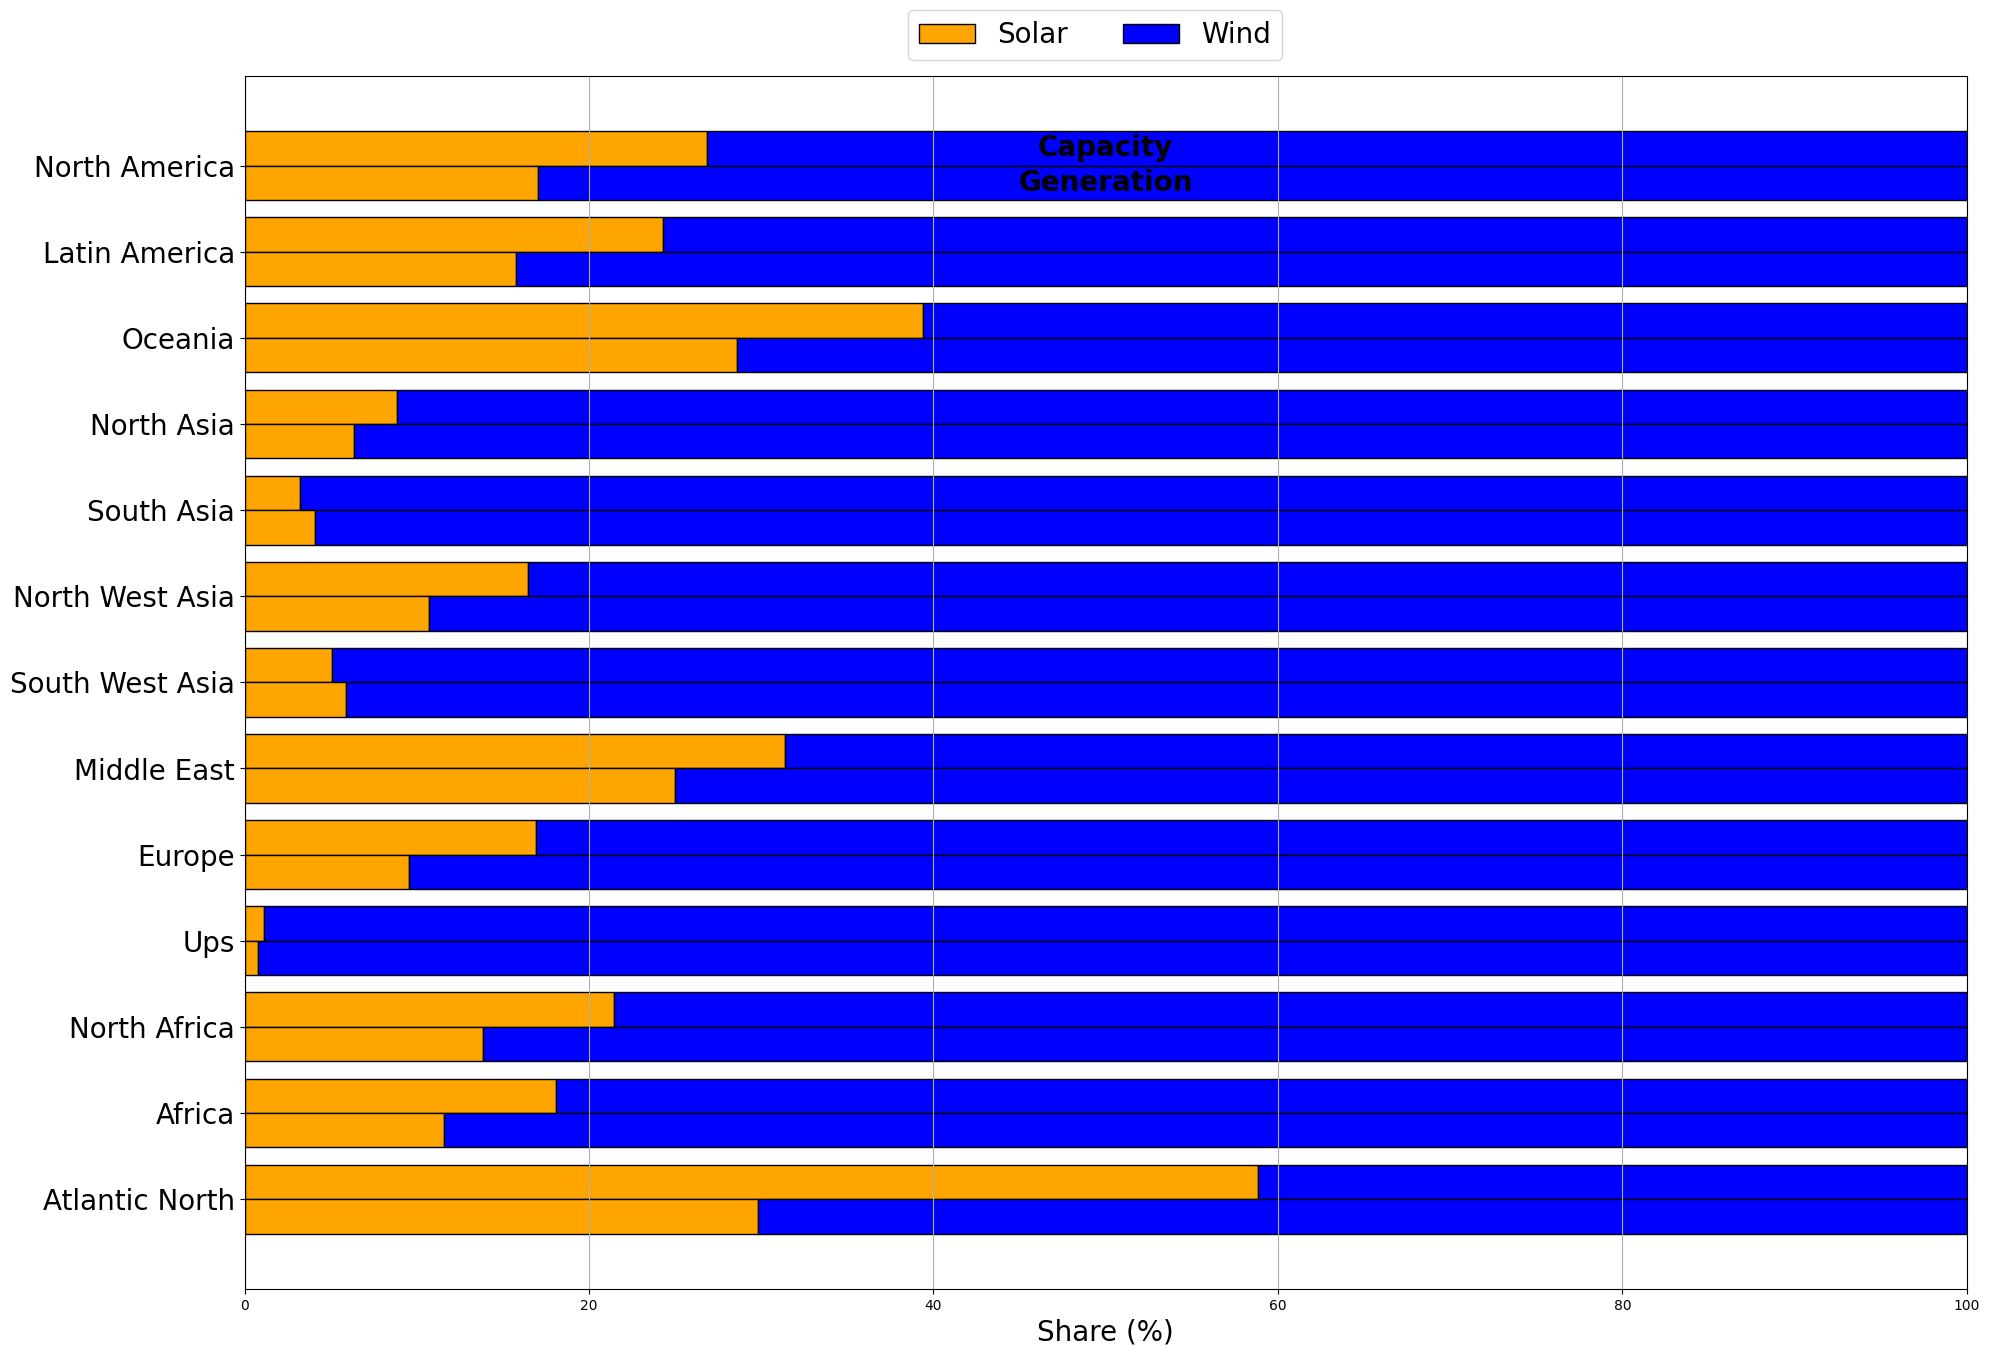

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate shares
regions = []
pv_cap_shares = []
wind_cap_shares = []
pv_gen_shares = []
wind_gen_shares = []

for key, value in regions_dic.items():
    regions.append(key)
    total_cap = value['wind_installed'] + value['pv_installed']
    total_gen = value['total_wind_yearly'] + value['total_pv_yearly']
    pv_cap_share = value['pv_installed'] / total_cap * 100
    wind_cap_share = 100 - pv_cap_share
    pv_gen_share = value['total_pv_yearly'] / total_gen * 100
    wind_gen_share = value['total_wind_yearly'] / total_gen * 100
    pv_cap_shares.append(pv_cap_share)
    wind_cap_shares.append(wind_cap_share)
    pv_gen_shares.append(pv_gen_share)
    wind_gen_shares.append(wind_gen_share)

# Define the number of regions
num_regions = len(regions)

# Create figure and axes
fig, ax = plt.subplots(figsize=(20, num_regions * 1))

# Bar width
bar_width = 0.4

# Plot Capacity shares
y_positions = np.arange(num_regions)
ax.barh(y_positions - bar_width/2, pv_cap_shares, height=bar_width, color='orange', edgecolor='black', label='Solar')
ax.barh(y_positions - bar_width/2, wind_cap_shares, height=bar_width, left=pv_cap_shares, color='blue', edgecolor='black', label='Wind')

# Plot Generation shares
ax.barh(y_positions + bar_width/2, pv_gen_shares, height=bar_width, color='orange', edgecolor='black')
ax.barh(y_positions + bar_width/2, wind_gen_shares, height=bar_width, left=pv_gen_shares, color='blue', edgecolor='black')

# Customizing the plot
formatted_regions = [region.replace('_', ' ').title() for region in regions]
ax.set_yticks(y_positions)
ax.set_yticklabels(formatted_regions, fontsize=20)
ax.set_xlim(0, 100)
ax.set_xlabel('Share (%)', fontsize=20)
ax.invert_yaxis()

# Add text annotations for capacity and generation
for i, (pv_cap, wind_cap, pv_gen, wind_gen) in enumerate(zip(pv_cap_shares, wind_cap_shares, pv_gen_shares, wind_gen_shares)):
    ax.text(50, i - bar_width/2, 'Capacity', ha='center', va='center', color='black', fontweight='bold', fontsize=20)
    ax.text(50, i + bar_width/2, 'Generation', ha='center', va='center', color='black', fontweight='bold', fontsize=20)
    break

# Add gridlines only for the x-axis
ax.grid(True, axis='x')

# Add the legend above the plot
plt.figlegend(loc='upper center', bbox_to_anchor=(0.55, 1.05), ncol=2, fontsize=20)

plt.tight_layout()
plt.show()


## Plotting of monthly regional data

## Tornado plot of annual regional data in 

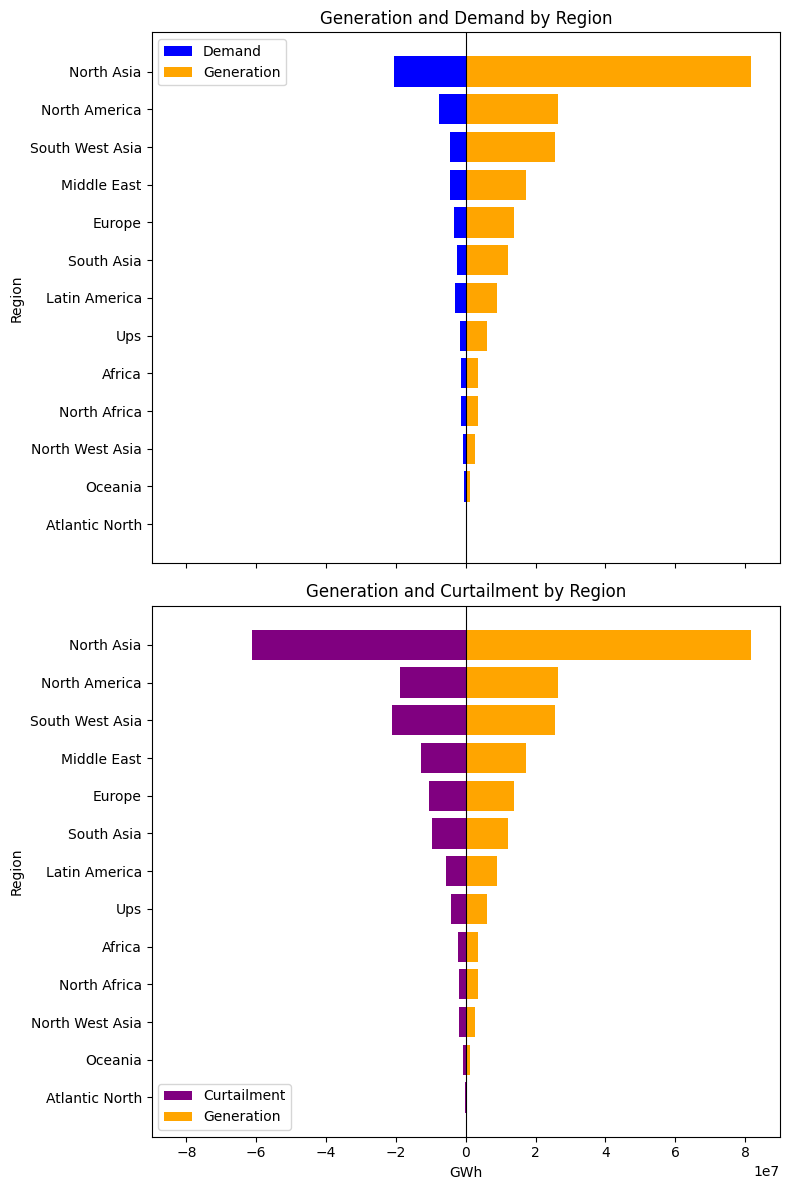

In [25]:
generation_demand_data = [
    (region_key.replace('_', ' ').title(), region_value['total_wind_yearly'] + region_value['total_pv_yearly'], region_value['total_load_yearly'])
    for region_key, region_value in regions_dic.items()
]
generation_demand_data.sort(key=lambda x: max(x[1], x[2]), reverse=True)

generation_curtailment_data = [
    (region_key.replace('_', ' ').title(), region_value['total_wind_yearly'] + region_value['total_pv_yearly'], region_value['total_curtailment_yearly'])
    for region_key, region_value in regions_dic.items()
]
generation_curtailment_data.sort(key=lambda x: max(x[1], x[2]), reverse=True)


regions_generation_demand = [item[0] for item in generation_demand_data]
generations_demand = [item[1] for item in generation_demand_data]
demands = [item[2] for item in generation_demand_data]

regions_generation_curtailment = [item[0] for item in generation_curtailment_data]
generations_curtailment = [item[1] for item in generation_curtailment_data]
curtailments = [item[2] for item in generation_curtailment_data]

fig, axs = plt.subplots(2, 1, figsize=(8, 12), sharex=True)

axs[0].barh(regions_generation_demand, [-demand for demand in demands], color='blue', label='Demand')
axs[0].barh(regions_generation_demand, generations_demand, color='orange', label='Generation')
axs[0].axvline(x=0, color='black', linewidth=0.8)
#axs[0].set_xlim(-e7, 2.2e7)
axs[0].set_ylabel('Region')
axs[0].set_title('Generation and Demand by Region')
axs[0].grid(False)
axs[0].legend()
axs[0].invert_yaxis()

axs[1].barh(regions_generation_curtailment, [-curtailment for curtailment in curtailments], color='purple', label='Curtailment')
axs[1].barh(regions_generation_curtailment, generations_curtailment, color='orange', label='Generation')
axs[1].axvline(x=0, color='black', linewidth=0.8)
axs[1].set_xlim(-9e7, 9e7)
axs[1].set_xlabel('GWh')
axs[1].set_ylabel('Region')
axs[1].set_title('Generation and Curtailment by Region')
axs[1].grid(False)
axs[1].legend()
axs[1].invert_yaxis()

plt.tight_layout()
plt.show()


In [9]:
for region_key, region_value in regions_dic.items():
    total_gen = region_value['total_wind_yearly'] + region_value['total_pv_yearly']
    total_cur = region_value['total_curtailment_yearly']
    cost = 1 + total_cur / total_gen
    print(region_key, cost)

north_america 1.6968110058822958
latin_america 1.664296928116535
oceania 1.669269113832497
north_asia 1.7714172366250716
south_asia 1.8641620182534009
north_west_asia 1.720999261898635
south_west_asia 1.8644108839218396
middle_east 1.752563408874802
europe 1.806749280890358
ups 1.965725842463726
north_africa 1.6160301429987343
africa 1.6046172211210186
atlantic_north 1.768289309044111


FileNotFoundError: [Errno 2] No such file or directory: '/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures/bar-chart-gen-netflow-demand-cur-no-trans.svg'

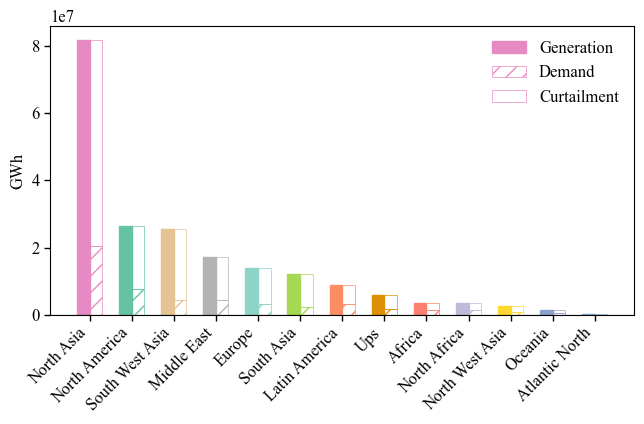

In [26]:
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.edgecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black'
})
generation_curtailment_data = [
    (region_key.replace('_', ' ').title(), region_value['total_wind_yearly'] + region_value['total_pv_yearly'], region_value['total_curtailment_yearly'])
    for region_key, region_value in regions_dic.items()
]
generation_curtailment_data.sort(key=lambda x: max(x[1], x[2]), reverse=True)

regions_generation_curtailment = [item[0] for item in generation_curtailment_data]
generations_curtailment = [item[1] for item in generation_curtailment_data]
curtailments = [item[2] for item in generation_curtailment_data]
demands = [gen - cur for gen, cur in zip(generations_curtailment, curtailments)]

# Plotting
fig, ax = plt.subplots(figsize=(6.6, 4.4))

# Bar chart for Generation and Curtailment by Region
bar_width = 0.3
x = range(len(regions_generation_curtailment))

hatch_patterns = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']  # Define different hatching patterns

for i, region in enumerate(regions_generation_curtailment):
    color = region_colors[region.lower().replace(' ', '_')]  # Get the color for the region from region_colors
    
    ax.bar(x[i], generations_curtailment[i], bar_width, label='Generation' if i == 0 else "", color=color, align='center', edgecolor=color)
    ax.bar(x[i] + bar_width, demands[i], bar_width, label='Demand' if i == 0 else "", color='none', edgecolor=color,hatch='//',  align='center', linewidth=0.5)
    ax.bar(x[i] + bar_width, curtailments[i], bar_width, bottom=demands[i], label='Curtailment' if i == 0 else "", color='none', edgecolor=color, align='center', linewidth=0.5)
    
ax.tick_params(axis='both', which='both', bottom=True, top=False, direction='out', length=4, width=1, color='black')
# Set x-ticks and labels
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(regions_generation_curtailment, rotation=45, ha='right')
ax.axhline(y=0, color='black', linewidth=0.8)
ax.set_ylabel('GWh')
ax.grid(False)

# Adjust the legend to show labels only once
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), frameon=False)
ax.tick_params(axis='y')
# Adjust layout
plt.tight_layout()
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures/bar-chart-gen-netflow-demand-cur-no-trans.svg', format='svg')
plt.show()


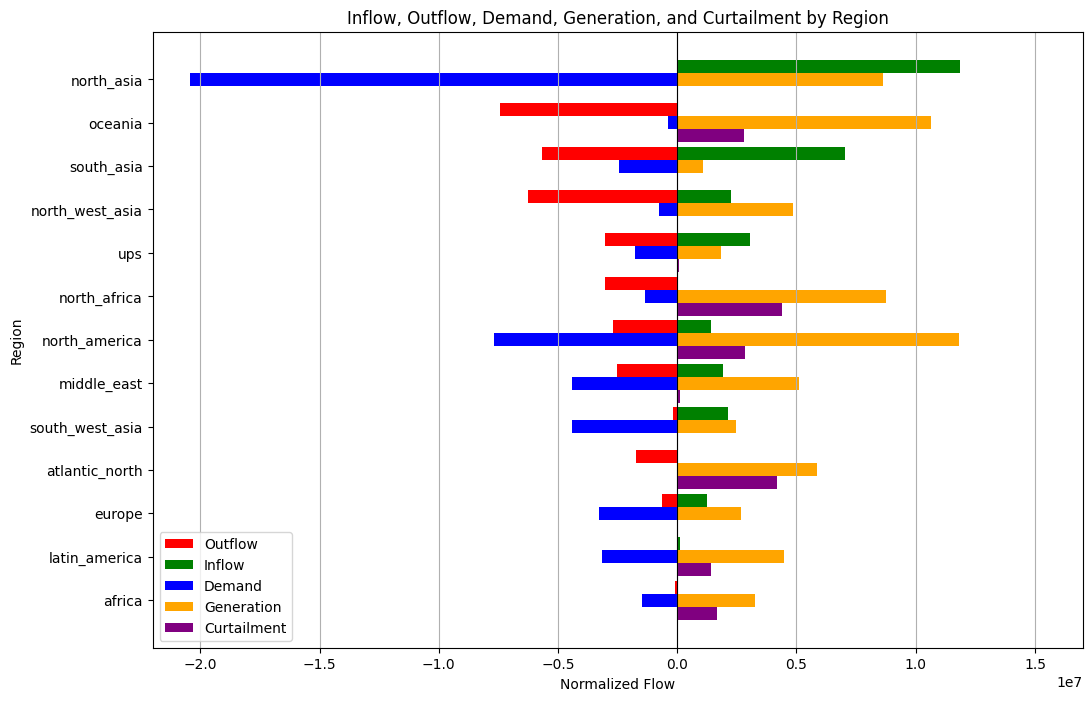

In [ ]:
regions_data = [
    (
        region_key,
        region_value['inflow'],  
        region_value['outflow'],  
        region_value['total_load_yearly'],  
        (region_value['total_wind_yearly'] + region_value['total_pv_yearly']),  
        region_value['total_curtailment_yearly'], 
        max(
            abs(region_value['inflow']),
            abs(region_value['outflow'])
        ) 
    )
    for region_key, region_value in regions_dic.items()
]

regions_data.sort(key=lambda x: x[6], reverse=False)

regions = [item[0] for item in regions_data]
inflows = [item[1] for item in regions_data]
outflows = [item[2] for item in regions_data]
loads = [item[3] for item in regions_data]
generations = [item[4] for item in regions_data]
curtailments = [item[5] for item in regions_data]

fig, ax = plt.subplots(figsize=(12, 8))

y_positions = range(len(regions))

ax.barh([y + 0.3 for y in y_positions], [-outflow for outflow in outflows], color='red', label='Outflow', height=0.3)
ax.barh([y + 0.3 for y in y_positions], inflows, color='green', label='Inflow', height=0.3)
ax.barh([y for y in y_positions], [-load for load in loads], color='blue', label='Demand', height=0.3)
ax.barh([y for y in y_positions], generations, color='orange', label='Generation', height=0.3)
ax.barh([y - 0.3 for y in y_positions], curtailments, color='purple', label='Curtailment', height=0.3)

ax.axvline(x=0, color='black', linewidth=0.8)

ax.grid(False, axis='y')
ax.grid(True, axis='x')

ax.set_xlabel('Normalized Flow')
ax.set_xlim(-2.2e7, 1.7e7)
ax.set_ylabel('Region')
ax.set_title('Inflow, Outflow, Demand, Generation, and Curtailment by Region')
ax.set_yticks([y for y in y_positions])
ax.set_yticklabels(regions)
ax.legend()

plt.show()


## Global Generation and demand graphs

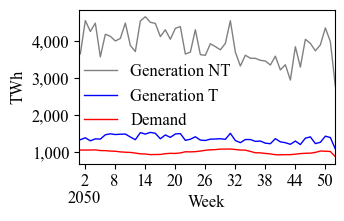

In [24]:
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.edgecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black'
})

# Group by week and sum the values
total_weekly_gen = total_hourly_gen.groupby(total_hourly_gen.index.to_period('W')).sum() * 1e-6
total_weekly_load = total_hourly_load.groupby(total_hourly_load.index.to_period('W')).sum() * 1e-6
total_weekly_cur = total_hourly_cur.groupby(total_hourly_cur.index.to_period('W')).sum() * 1e-6
# Remove the first entry
total_weekly_gen = total_weekly_gen.iloc[1:]
total_weekly_load = total_weekly_load.iloc[1:]
total_weekly_cur = total_weekly_cur.iloc[1:]
# Extract the week numbers and values
weeks = total_weekly_gen.index.to_timestamp()  # Convert period index to timestamp for plotting
values_gen = total_weekly_gen.values
values_load = total_weekly_load.values
values_gen_no_trans = pd.read_csv('weekly_gen_trans.csv', index_col=0).values
values_cur = total_weekly_cur.values
# Plotting
plt.figure(figsize=(3.3, 2))

# Plot load on top
plt.plot(weeks, values_gen, label='Generation NT', linestyle='-', color='grey', linewidth=1)
plt.plot(weeks, values_gen_no_trans, label='Generation T', linestyle='-', color='blue', linewidth=1)
plt.plot(weeks, values_load, label='Demand', linestyle='-', color='red', linewidth=1)
plt.xlabel('Week', fontsize=12)
plt.ylabel('TWh', fontsize=12)
plt.legend(bbox_to_anchor=(-0.04, 0.13), loc='lower left', frameon=False)  # Add a legend to the plot
plt.gca().annotate('2050', xy=(0.02, -0.23), xycoords='axes fraction', ha='center', va='center')
# Create a range of weeks
all_weeks = pd.date_range(start=weeks[0], periods=52, freq='W')
plt.xlim(pd.Timestamp('2050-01-01'), pd.Timestamp('2050-12-25'))
# Customize x-axis ticks to show every 4th week
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%-U'))  # Remove leading zeros
plt.xticks(all_weeks[::6], fontsize=12)
plt.yticks([1000, 2000, 3000, 4000])
ax = plt.gca()
def format_func(value, tick_number):
    return f'{value:,.0f}'

formatter = FuncFormatter(format_func)
plt.gca().yaxis.set_major_formatter(formatter)
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/weekly-gen-demand-no-trans.svg', format='svg')

# Show the plot
plt.show()

In [19]:
# Group by week and sum the values
total_weekly_gen = total_hourly_gen.groupby(total_hourly_gen.index.to_period('W')).sum()

# Reset index to get a DataFrame
total_weekly_gen = total_weekly_gen.reset_index()

# Extract the week numbers from the period index
total_weekly_gen['Week'] = total_weekly_gen['index'].apply(lambda x: x.week)

# Remove any week 0 entries (if they exist)
total_weekly_gen = total_weekly_gen[total_weekly_gen['Week'] != 0]

# Extract the week numbers and values
weeks = total_weekly_gen['Week']
values = total_weekly_gen[0]  # Assuming the data values are in the first column

# Plotting
plt.figure(figsize=(12, 8))

# Plot load on top
plt.plot(weeks, values, label='Load', linestyle='--', color='red', linewidth=4)
plt.xlabel('Week', fontsize=16)
plt.ylabel('MW', fontsize=16)
plt.legend()  # Add a legend to the plot

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Tight layout to ensure everything fits without overlapping
plt.tight_layout()

# Show the plot
plt.show()

KeyError: 'index'

## Demand and supply graphs of each regions


north_america


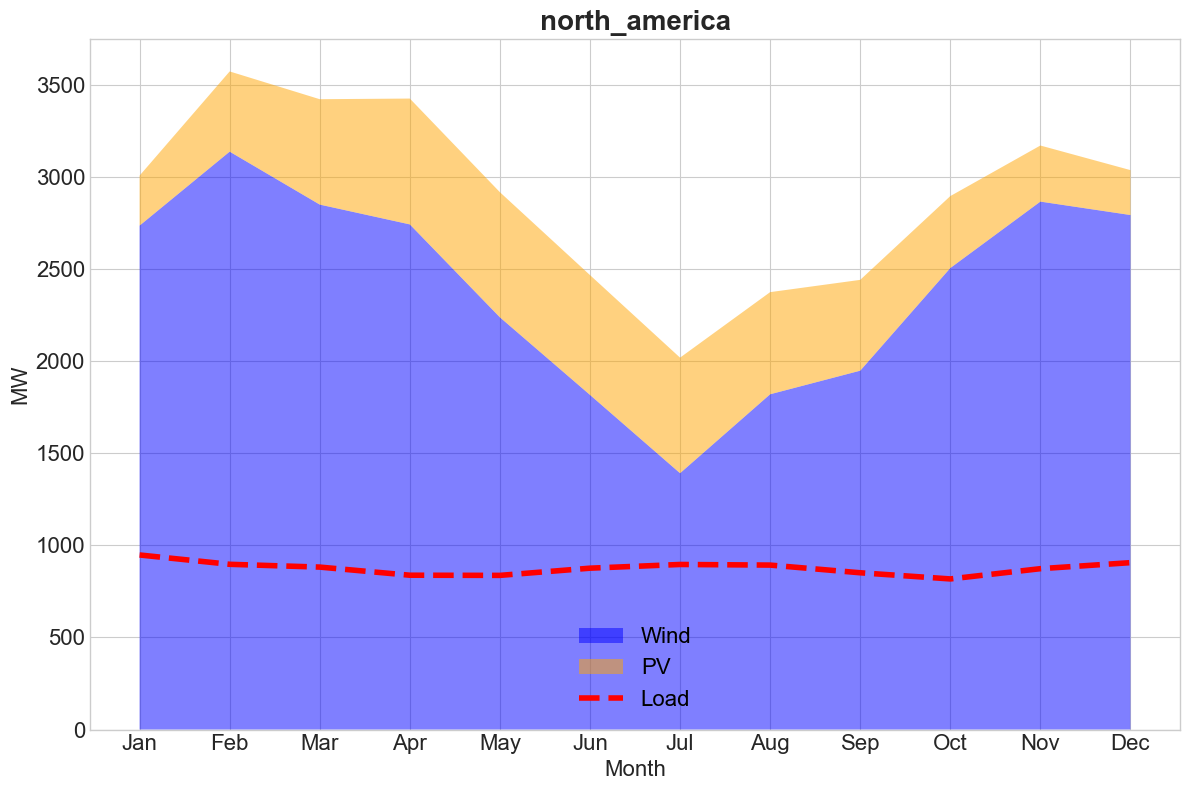

latin_america


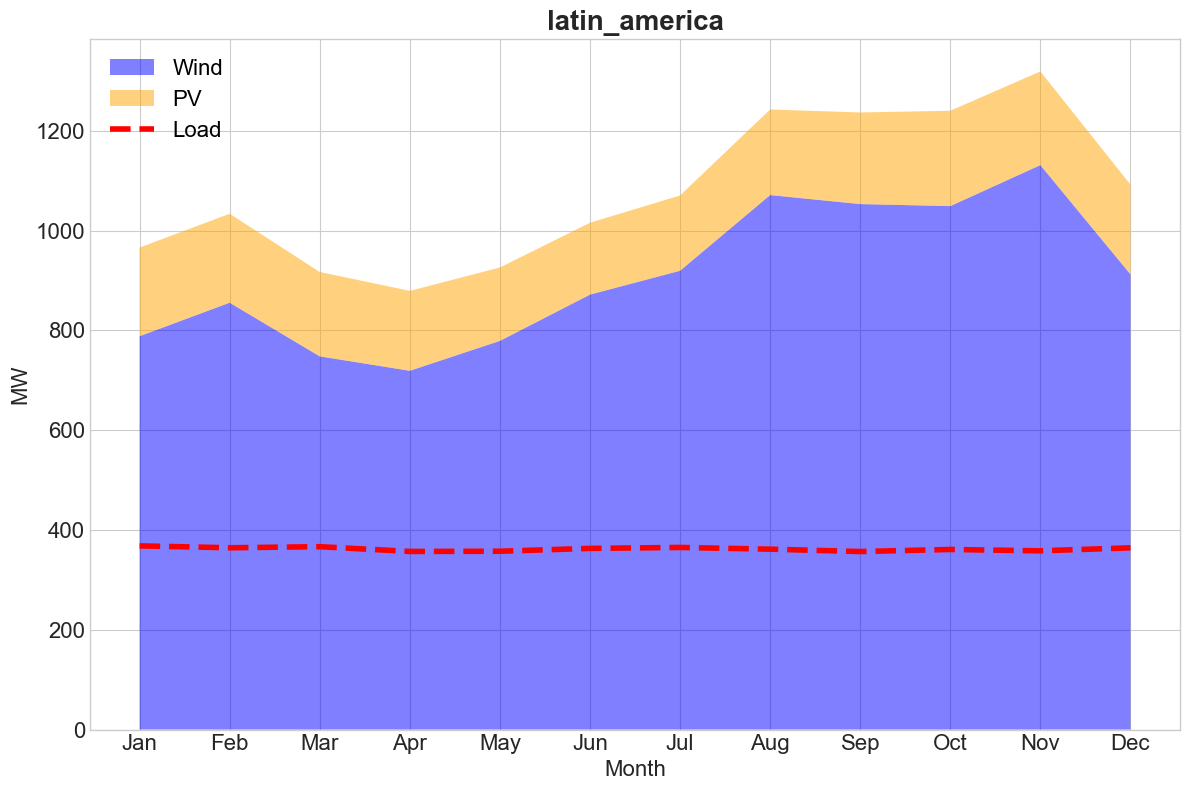

oceania


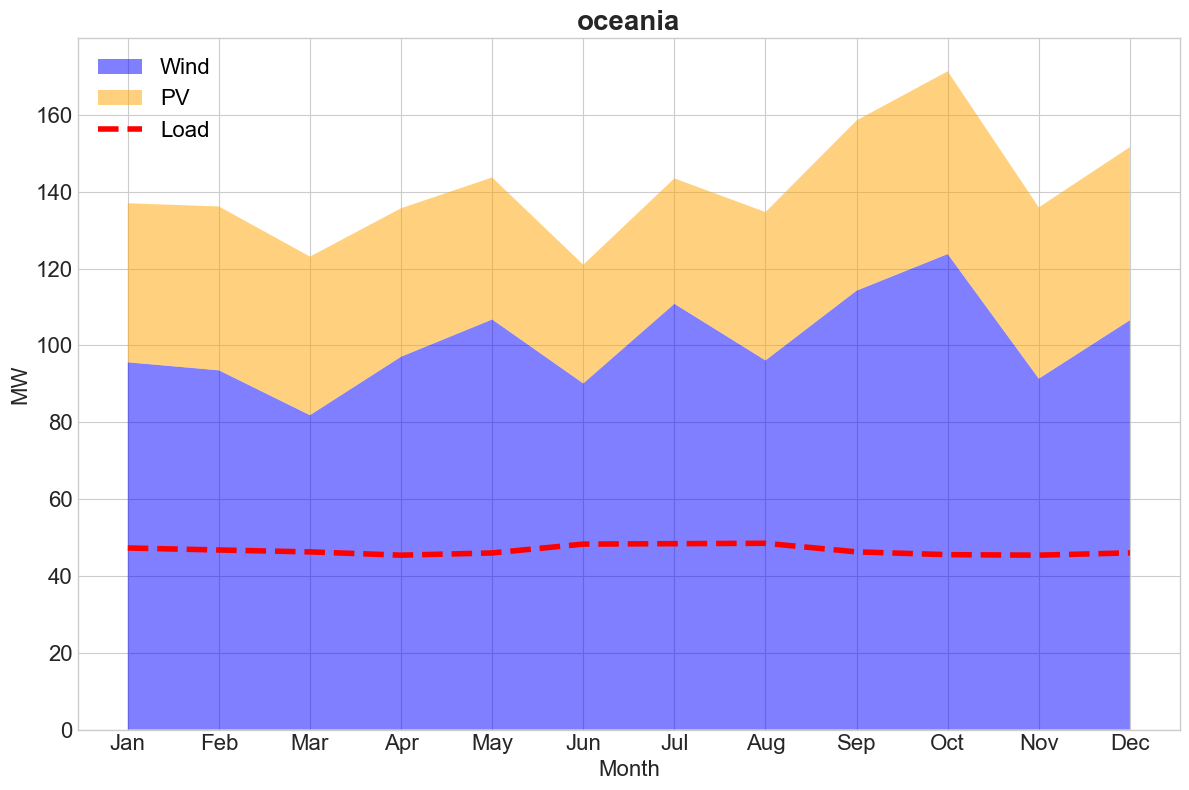

north_asia


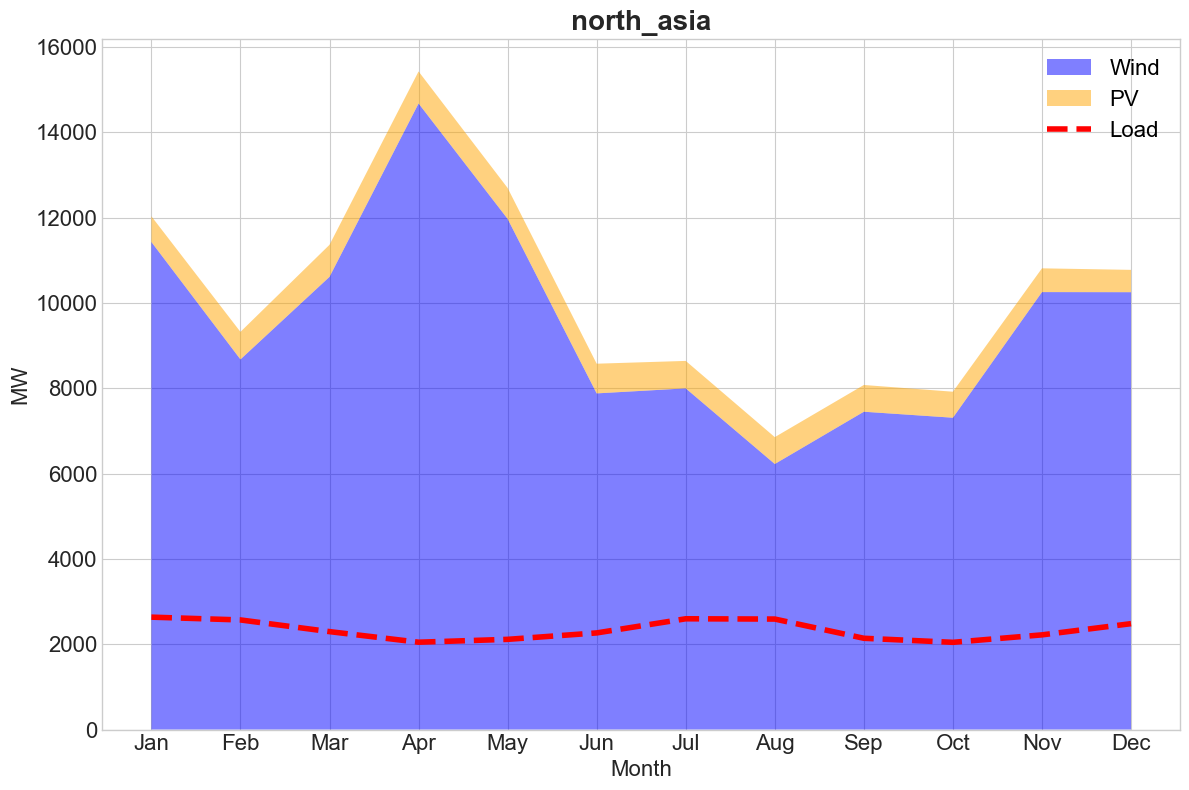

south_asia


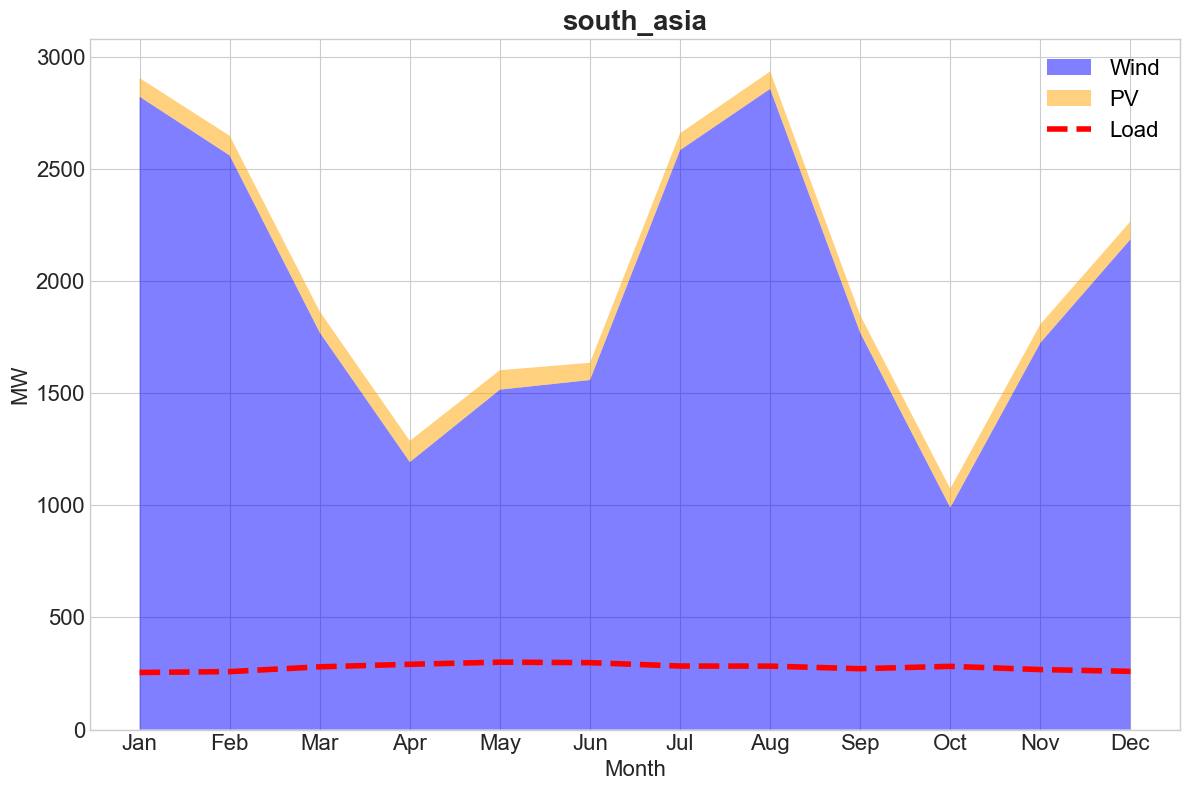

north_west_asia


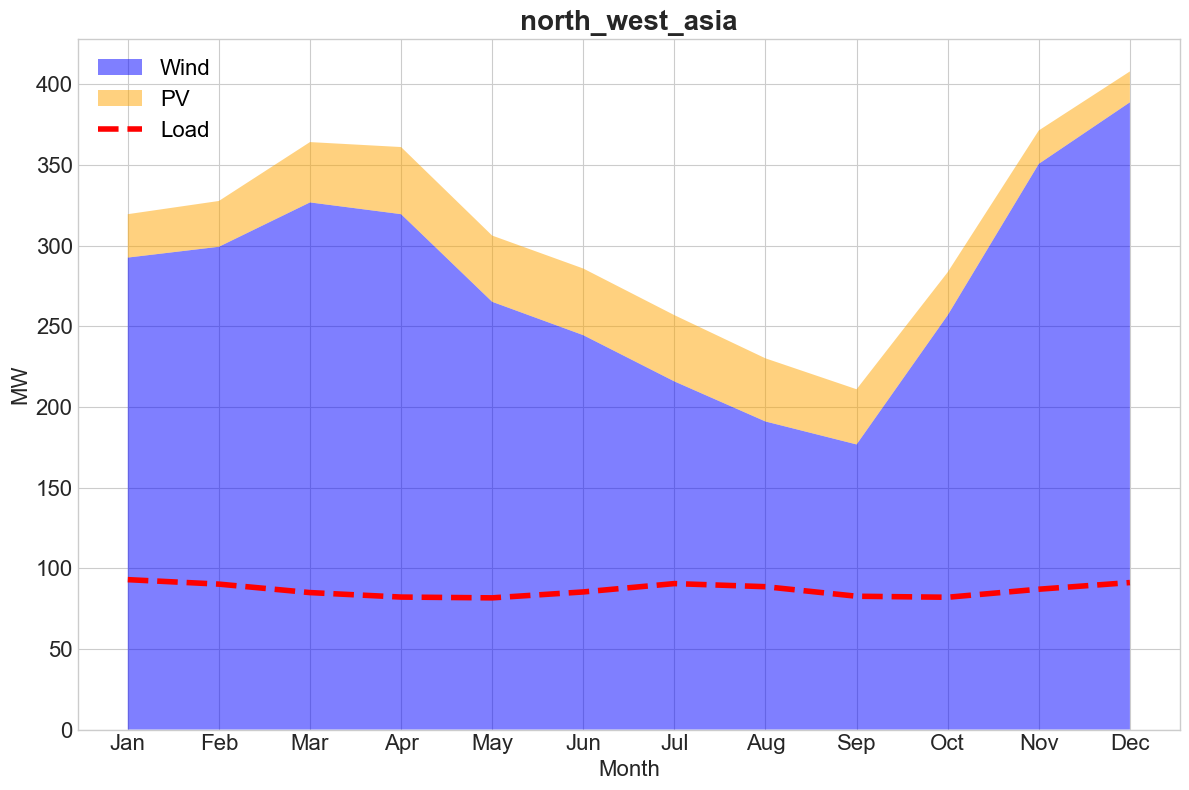

south_west_asia


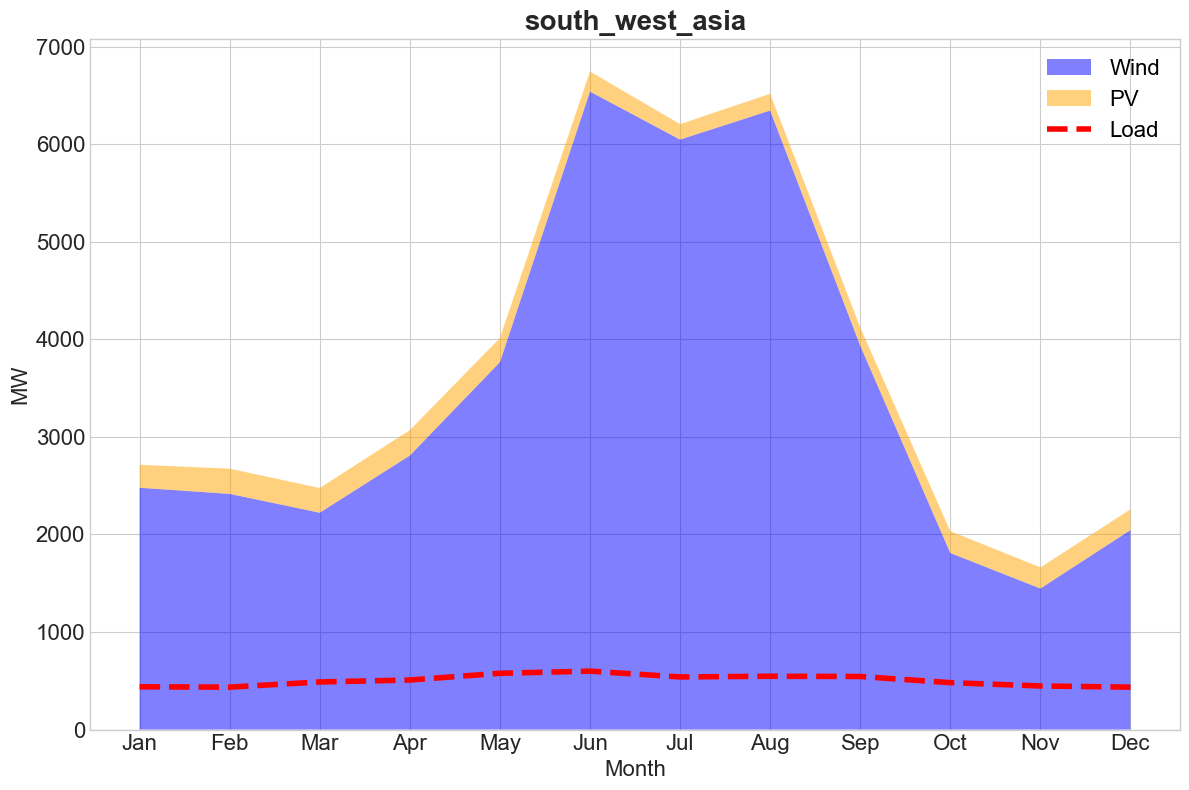

middle_east


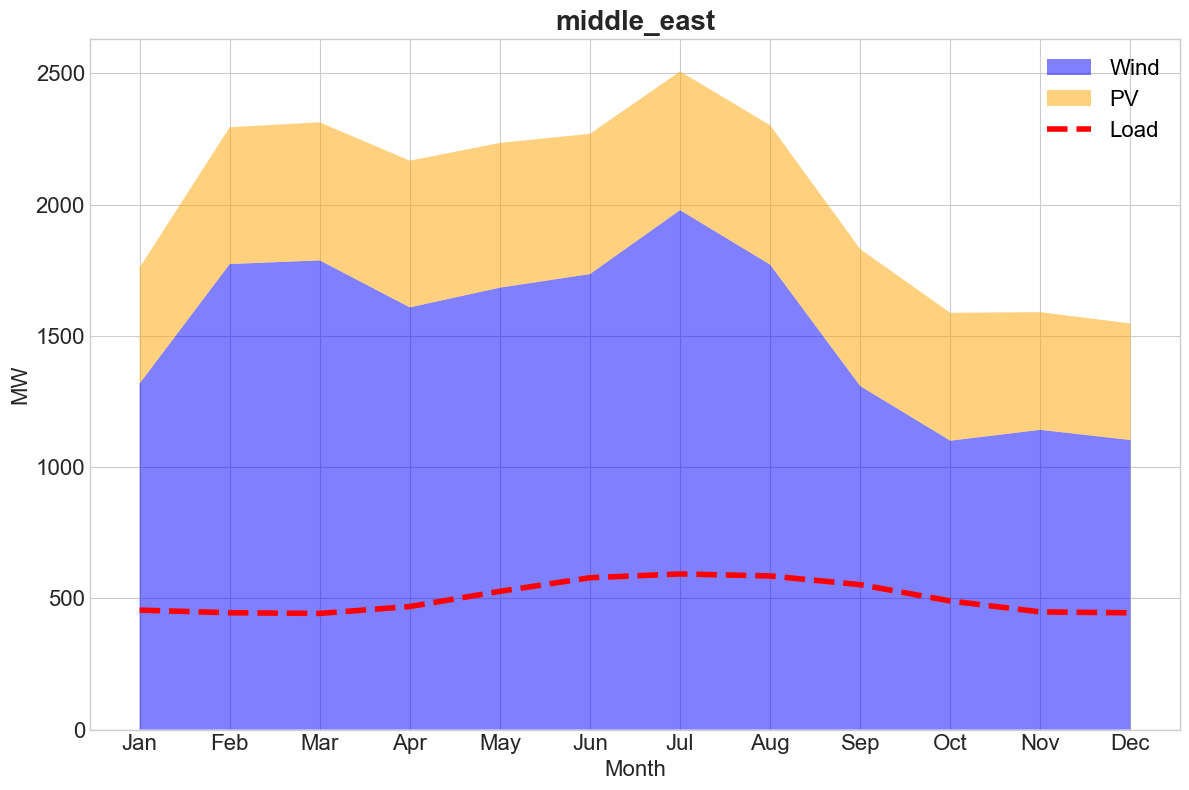

europe


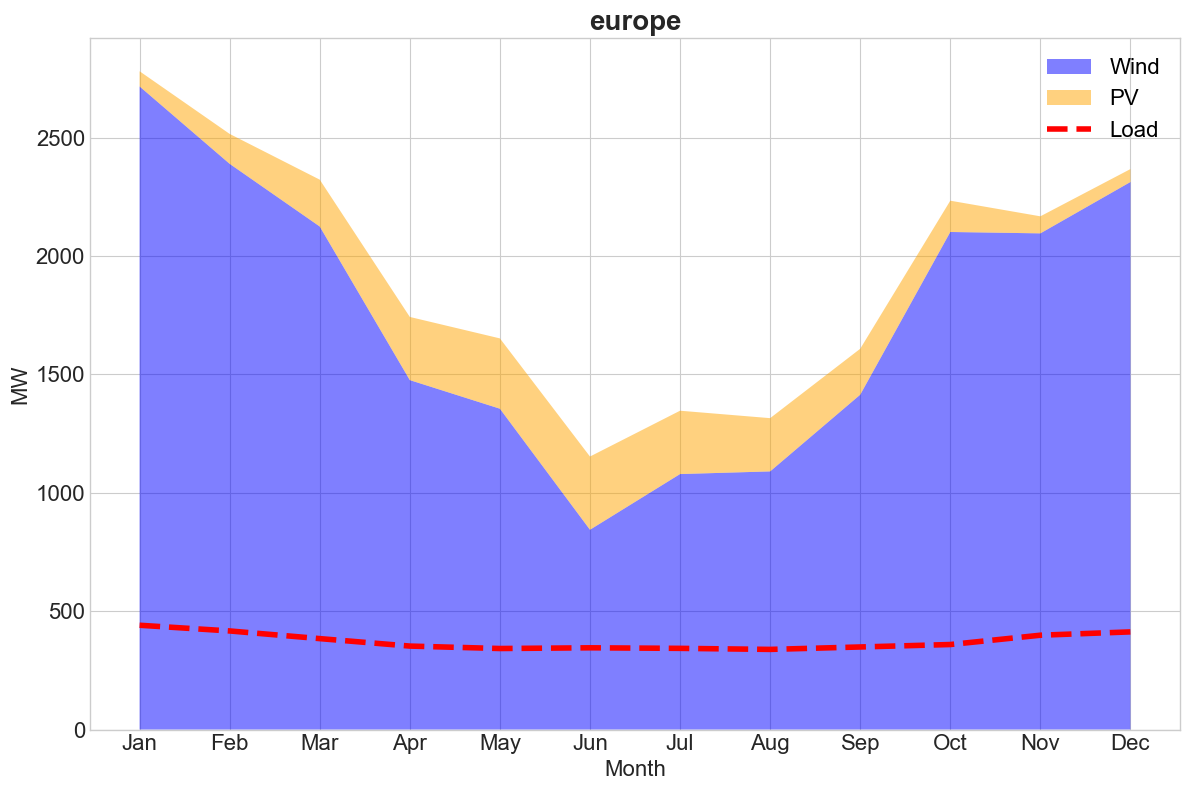

ups


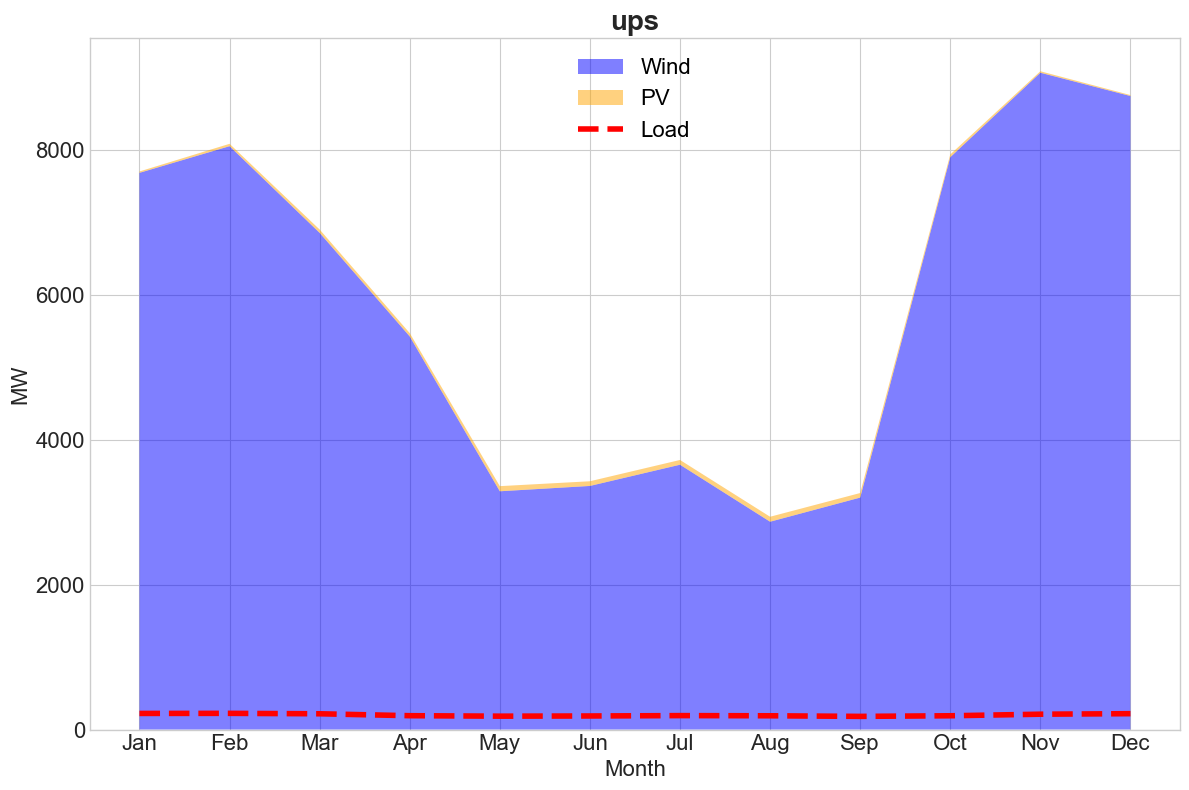

north_africa


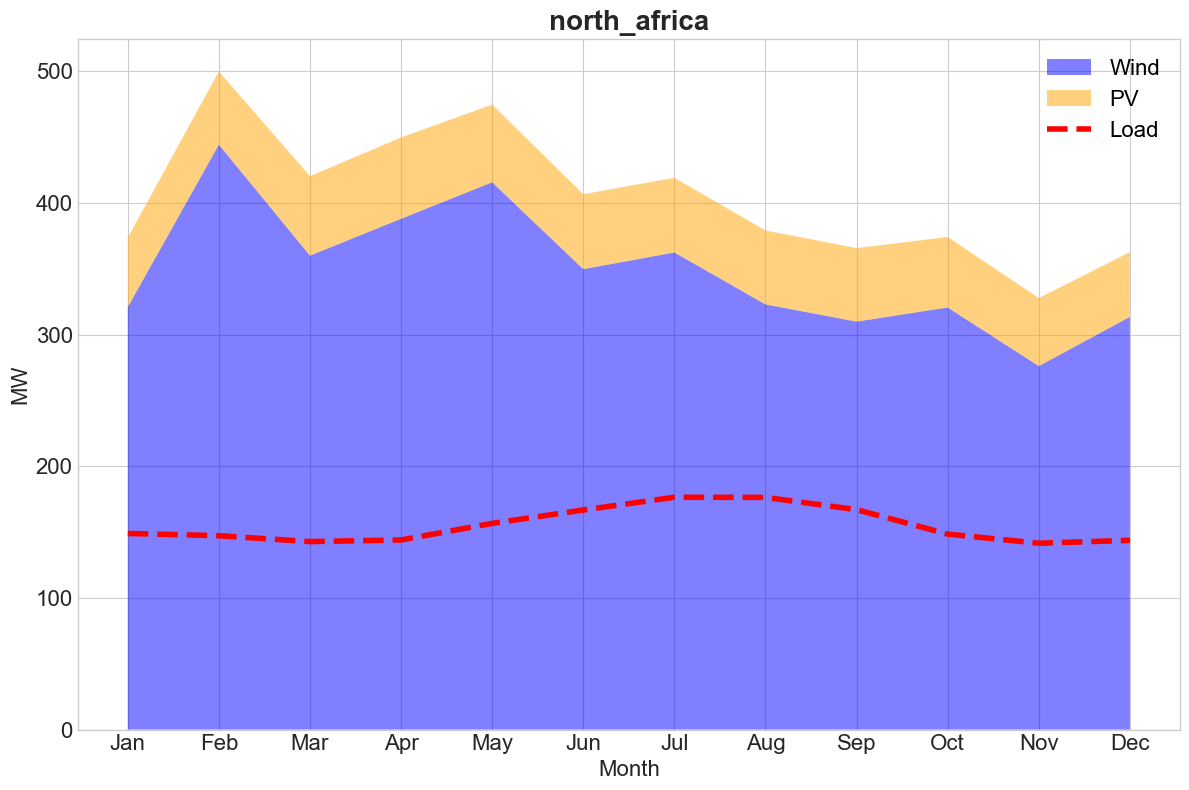

africa


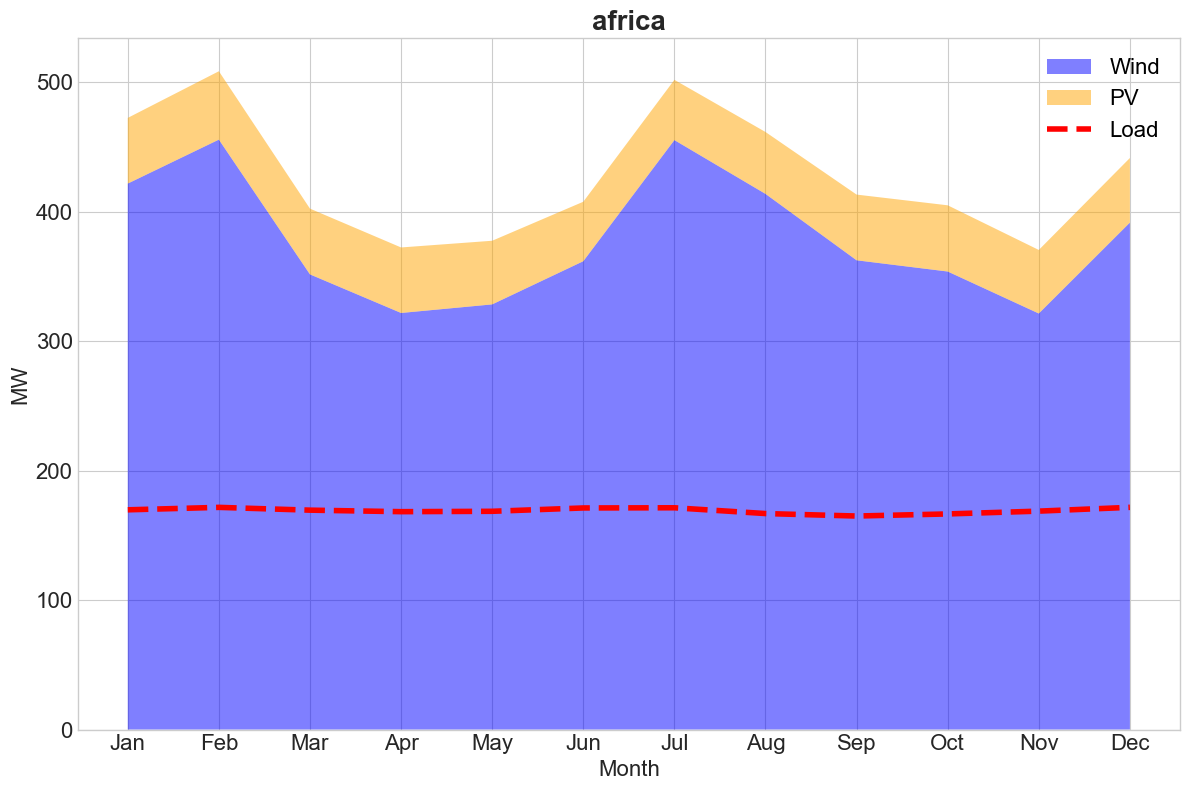

atlantic_north


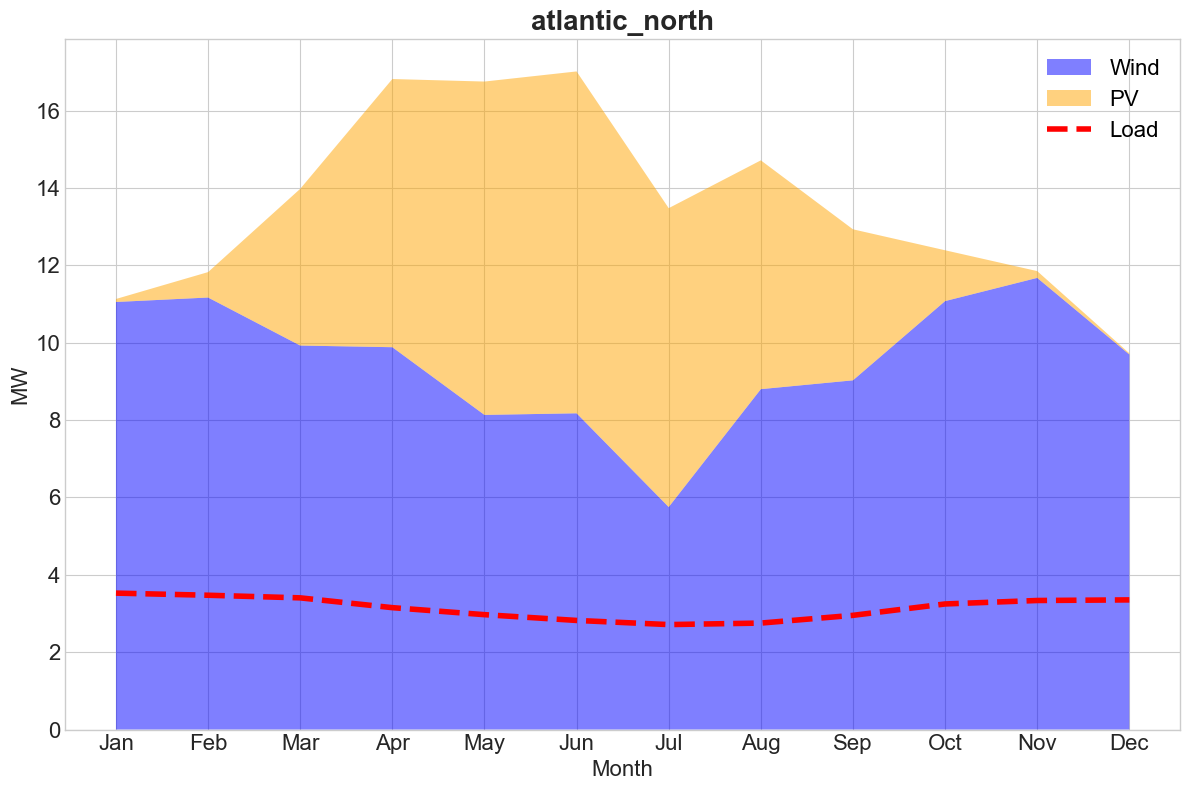

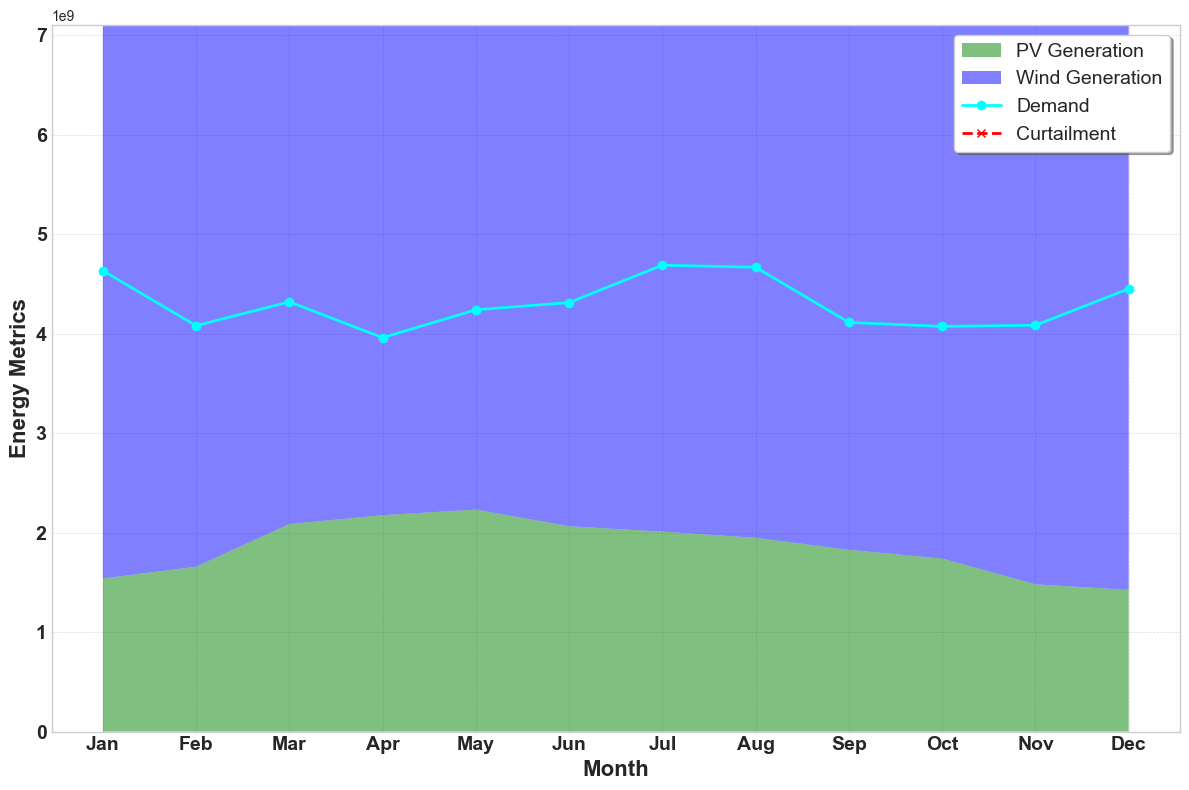

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')  

for key, value in regions_dic.items():
    print(key)
    # series_l = value["load"]
    # load = series_l.groupby(series_l.index.to_period('M')).sum()
    load = value['mean_load_monthly']
    wind = value["mean_wind_monthly"]
    pv = value["mean_pv_monthly"]

    # Extract values and months
    months = load.index.month
    load_values = load.values
    wind_values = wind.values
    pv_values = pv.values

    plt.figure(figsize=(12, 8))
    
    # # Stacked area plot for wind and PV
    plt.stackplot(months, wind_values, pv_values, labels=['Wind', 'PV'], colors=['blue', 'orange'], alpha=0.5)
    
    # Plot load on top
    plt.plot(months, load_values, label='Load', linestyle='--', color='red', linewidth=4)
    
    plt.title(f'{key}', fontsize=20, fontweight='bold')
    plt.xlabel('Month', fontsize=16)
    plt.ylabel('MW', fontsize=16)
    legend = plt.legend(loc='best', fontsize=16)
    for text in legend.get_texts():
        text.set_color('black')  # Set legend text color to black
        #text.set_fontweight('bold')  # Make legend text bold
    # Customize ticks
    plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=16)
    plt.yticks(fontsize=16)
    # Tight layout to ensure everything fits without overlapping
    plt.tight_layout()
    
    
    # Show the plot
    plt.show()

plt.figure(figsize=(12, 8))  # Increase figure size for better readability
# Plot line plots for Demand and Curtailment
# Plot stackplot for PV and wind generation
plt.stackplot(total_monthly_pv.index.month, total_monthly_pv.values, total_monthly_wind.values, labels=['PV Generation', 'Wind Generation'], colors=['green', 'blue'], alpha=0.5)
plt.plot(total_monthly_pv.index.month, total_monthly_load, label='Demand', color='cyan', linewidth=2, linestyle='-', marker='o')
plt.plot(total_monthly_pv.index.month, total_monthly_cur, label='Curtailment', color='red', linewidth=2, linestyle='--', marker='x')
plt.xlabel('Month', fontsize=16, fontweight='bold')  # Increase font size
plt.ylabel('Energy Metrics', fontsize=16, fontweight='bold')  # Increase font size and add a more descriptive label
plt.ylim(0, 7.1e9)
plt.legend(loc='upper right', fontsize=14, frameon=True, shadow=True)  # Move legend to upper left, increase font size, add frame and shadow
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Add grid for better readability

plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=14, fontweight='bold')  # Increase x-tick font size and labels
plt.yticks(fontsize=14, fontweight='bold')  # Increase y-tick font size

plt.tight_layout()  # Adjust layout to fit elements better
plt.show()

# **Maps**

## Global grid map

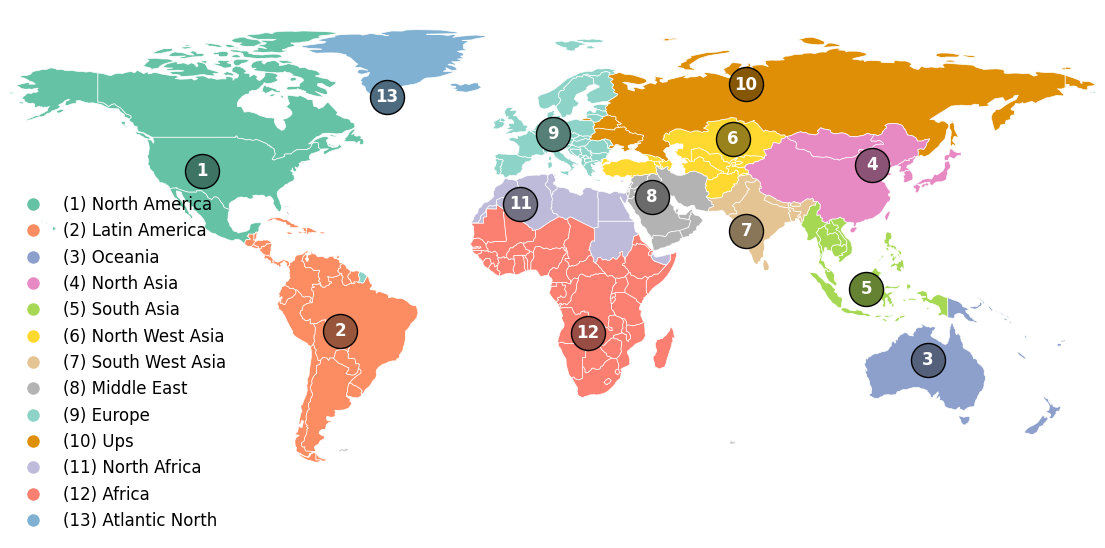

In [7]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from pyproj import Geod
import geopandas as gpd
from cartopy.geodesic import Geodesic
import matplotlib.colors as mcolors

plt.rc("figure", figsize=(14, 10))
# Function to convert RGB tuple to hex
def rgb_to_hex(rgb):
    return mcolors.to_hex(rgb)

def darken_color(color, factor=0.8):
    """
    Darkens a color by a given factor.
    color: The color to be darkened (in RGB or hex format).
    factor: The factor to darken the color (default is 0.8).
    """
    rgb = mcolors.to_rgb(color)  # Convert to RGB if in hex
    darker_rgb = [factor * c for c in rgb]  # Apply factor to each component
    return mcolors.to_hex(darker_rgb)  # Convert back to hex

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Remove Antarctica
world = world[world['name'] != "Antarctica"]
# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

# Manually assign French Guiana to Latin America
world.loc[world['name'] == 'France', 'bus'] = world.loc[world['name'] == 'France'].apply(
    lambda row: 'latin_america' if row['continent'] == 'South America' else row['bus'],
    axis=1
)

# Ensure that we have unique regions in the order defined in regions_dic
ordered_regions = [key for key in regions_dic if key in world['bus'].unique()]

# Convert colors to hex
colors = [rgb_to_hex(region_colors[bus]) if bus in region_colors else '#cccccc' for bus in world['bus']]

# Plotting the network with results
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)})
ax.set_extent([-180, 180, -80, 90], crs=ccrs.PlateCarree())  # Adjust extent as needed


# Plot country regions with assigned colors
world.plot(ax=ax, color=colors, edgecolor='white', legend=False,transform=ccrs.PlateCarree(), linewidth=0.5)
# Create a custom legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=region_colors[region], markersize=10, label=f'({i+1}) {region.replace('_', ' ').title()}')
    for i, region in enumerate(ordered_regions)
]
ax.legend(
    handles=handles, 
    loc='lower left', 
    bbox_to_anchor=(-0.008, -0.013), 
    bbox_transform=ax.transAxes, 
    fancybox=False, 
    shadow=False, 
    ncol=1, 
    fontsize=12, 
    frameon=False, 
    framealpha=1, 
    edgecolor='black'
)

for i, bus in enumerate(n.buses.index, start=1):
    color_ = color_ = darken_color(region_colors[bus], factor=0.6)
    x, y = n.buses.loc[bus, ['x', 'y']]
    ax.scatter(x, y, s=600, color=color_, edgecolor='black', zorder=5, linewidths=1, transform=ccrs.PlateCarree())
    ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6, fontweight='bold', transform=ccrs.PlateCarree())

# Plot links
for i, link in enumerate(n.links.index[0::2]):
    if link != 'north_america_to_ups_0':
        bus0 = n.links.loc[link, 'bus0']
        bus1 = n.links.loc[link, 'bus1']
        x0, y0 = n.buses.loc[bus0, ['x', 'y']]
        x1, y1 = n.buses.loc[bus1, ['x', 'y']]
        ax.plot([x0, x1], [y0, y1], color='black', linewidth=2, zorder=4, transform=ccrs.PlateCarree())
    else:
        bus0 = n.links.loc['north_america_to_ups_0', 'bus0']
        bus1 = n.links.loc['north_america_to_ups_0', 'bus1']
        x0, y0 = n.buses.loc[bus0, ['x', 'y']]    
        x1, y1 = -143, n.buses.loc[bus1, ['x', 'y']]['y']
        ax.plot([x0, x1], [y0, y1], color='black', linewidth=2, zorder=4, transform=ccrs.PlateCarree())
        x0, y0 = x1+0.9, y1    
        x1, y1 = -160, y1
        ax.annotate('', xy=(x1, y1), xytext=(x0, y0),
            arrowprops=dict(arrowstyle='->', color='black', linewidth=2), transform=ccrs.PlateCarree()) 
        ax.text(-165, y1, '10', color='black', fontsize=12, ha='left', va='top', zorder=6, fontweight='bold', transform=ccrs.PlateCarree()) 
        x0, y0 = 177, y1    
        x1, y1 = n.buses.loc[bus1, ['x', 'y']]
        ax.annotate('', xy=(x0, y0), xytext=(x1, y1),
            arrowprops=dict(arrowstyle='->', color='black', linewidth=2), transform=ccrs.PlateCarree()) 
        ax.text(x0+2, y0, '1', color='black', fontsize=12, ha='right', va='top', zorder=6, fontweight='bold', transform=ccrs.PlateCarree())     
ax.spines['geo'].set_visible(False)
plt.savefig(f'/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/global-grid-map.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()


## Heat maps

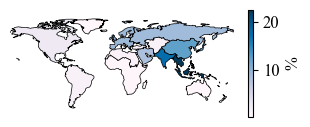

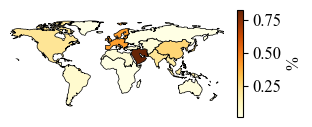

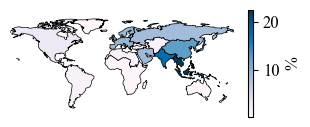

In [ ]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
from matplotlib.colors import Normalize
import matplotlib.cm as cm

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(3.3, 2.5))

installed_capacity_wind_dic = {}
installed_capacity_pv_dic = {}
installed_cap_pv_area = {}
installed_cap_wind_area = {}
curtailment_rel_to_gen = {}
loads_dic = {}
generation_area_dic = {}
generation_dic = {}
installed_cap_land_share = {}
for key, value in regions_dic.items():
    area = region_area(key)
    installed_cap_wind_area[key] = value["wind_installed"] / wind_density / area * 1e9 * 100 # to go from GW to to W
    installed_cap_pv_area[key] = value["pv_installed"] / pv_density / area * 1e9 * 100
    installed_cap_land_share[key] = installed_cap_wind_area[key] + installed_cap_pv_area[key]

values_dics = [installed_cap_wind_area,  installed_cap_pv_area, installed_cap_land_share]

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Remove Antarctica
world = world[world['name'] != "Antarctica"]
# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

for i, values_dic in enumerate(values_dics):
    # Add the values to the world GeoDataFrame
    world['value'] = world['bus'].map(values_dic)

    # Merge countries into regions, aggregating only the 'value' column
    regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})

    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)})
    ax.set_extent([-180, 180, -62, 90], crs=ccrs.PlateCarree())  # Adjust extent as needed

    # Normalize the values for the colormap
    norm = Normalize(vmin=min(values_dic.values()), vmax=max(values_dic.values()))
    cmap = cm.PuBu
    if i == 1:
        cmap = cm.YlOrBr

    # Plot regions with the heatmap, making sure normalization is applied
    regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree(), linewidth=0.5)

    # for i, bus in enumerate(n.buses.index, start=1):
    #     x, y = n.buses.loc[bus, ['x', 'y']]
    #     ax.scatter(x, y, s=400, color='black', edgecolor='k', zorder=5)
    #     ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6)

    # Add a title to the figure
    if i == 0:
        pass
        #plt.title('Land Use of Installed Wind Capacity', fontsize=16)
    elif i == 1:
        pass
        #plt.title('Land Use of Installed PV Capacity', fontsize=16)
    elif i == 2:
        pass
        #plt.title('Land Use of Total Installed Capacity', fontsize=16)

    # Create and customize the color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  # Dummy array for the scalar mappable
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
    cbar.set_label('%')

    ax.spines['geo'].set_visible(False)
    if i == 0:
        plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures/wind-land-use-no-trans.svg', format='svg')
    elif i == 1:
        plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures/pv-land-use-no-trans.svg', format='svg')
    elif i == 2:
        plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures/total-land-use-no-trans.svg', format='svg')
    plt.tight_layout()
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures/wind-pv-land-use-no-trans.svg'

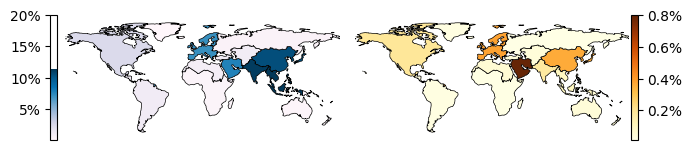

In [7]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
from matplotlib.colors import Normalize
import matplotlib.cm as cm

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(6.6, 2.5))

installed_capacity_wind_dic = {}
installed_capacity_pv_dic = {}
installed_cap_pv_area = {}
installed_cap_wind_area = {}
curtailment_rel_to_gen = {}
loads_dic = {}
generation_area_dic = {}
generation_dic = {}
installed_cap_land_share = {}
for key, value in regions_dic.items():
    area = region_area(key)
    installed_cap_wind_area[key] = value["wind_installed"] / wind_density / area * 1e9 * 100  # to go from GW to to W
    installed_cap_pv_area[key] = value["pv_installed"] / pv_density / area * 1e9 * 100
    installed_cap_land_share[key] = installed_cap_wind_area[key] + installed_cap_pv_area[key]

values_dics = [installed_cap_wind_area, installed_cap_pv_area, installed_cap_land_share]

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Remove Antarctica
world = world[world['name'] != "Antarctica"]
# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)}, figsize=(6.6, 2.5))

for i, ax in enumerate(axes):
    values_dic = values_dics[i]
    # Add the values to the world GeoDataFrame
    world['value'] = world['bus'].map(values_dic)

    # Merge countries into regions, aggregating only the 'value' column
    regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})

    ax.set_extent([-180, 180, -62, 90], crs=ccrs.PlateCarree())  # Adjust extent as needed

    # Normalize the values for the colormap
    norm = Normalize(vmin=min(values_dic.values()), vmax=max(values_dic.values()))
    cmap = cm.PuBu if i == 0 else cm.YlOrBr

    # Plot regions with the heatmap, making sure normalization is applied
    regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree(), linewidth=0.5)

    ax.spines['geo'].set_visible(False)

    # Create and customize the color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  # Dummy array for the scalar mappable
    
    if i == 0:
        cax = fig.add_axes([0.05, 0.25, 0.01, 0.5])  # Adjust position and width as needed
        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        cbar.ax.yaxis.set_ticks_position('left')
        cbar.ax.yaxis.set_label_position('left')
        cbar.set_ticks([5, 10, 15, 20])  # Customize the ticks
        cbar.set_ticklabels(['5%', '10%', '15%','20%'])  # Customize the tick labels
    else:
        cax = fig.add_axes([0.93, 0.25, 0.01, 0.5])  # Adjust position and width as needed
        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        cbar.set_ticks([0.2, 0.4, 0.6, 0.8])  # Customize the ticks
        cbar.set_ticklabels(['0.2%', '0.4%', '0.6%','0.8%'])  # Customize the tick labels

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])  # Adjust layout to prevent overlap
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures/wind-pv-land-use-no-trans.svg', format='svg')
plt.show()


north_america 0.1893179945540204
latin_america 0.022119652547847177
oceania 0.04394204889380676
north_asia 0.36081518087238984
south_asia 0.09882698226420872
north_west_asia 0.04192842819623548
south_west_asia 0.17146358238995782
middle_east 0.7914862819445334
europe 0.3832122388448707
ups 0.012842637408892445
north_africa 0.05676488709377631
africa 0.016875399613504195
atlantic_north 0.023916407919214684


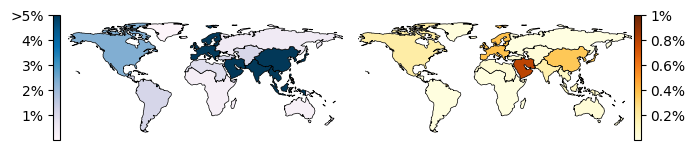

In [9]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
from matplotlib.colors import Normalize
import matplotlib.cm as cm

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(6.6, 2.5))
wind_density = 10
pv_density = 45
installed_capacity_wind_dic = {}
installed_capacity_pv_dic = {}
installed_cap_pv_area = {}
installed_cap_wind_area = {}
curtailment_rel_to_gen = {}
loads_dic = {}
generation_area_dic = {}
generation_dic = {}
installed_cap_land_share = {}
for key, value in regions_dic.items():
    area = region_area(key)
    installed_cap_wind_area[key] = value["wind_installed"] / wind_density / area * 1e9 * 100  # to go from GW to to W
    installed_cap_pv_area[key] = value["pv_installed"] / pv_density / area * 1e9 * 100
    installed_cap_land_share[key] = installed_cap_wind_area[key] + installed_cap_pv_area[key]
    print(key, installed_cap_pv_area[key])

values_dics = [installed_cap_wind_area, installed_cap_pv_area, installed_cap_land_share]

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Remove Antarctica
world = world[world['name'] != "Antarctica"]
# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)}, figsize=(6.6, 2.5))

for i, ax in enumerate(axes):
    values_dic = values_dics[i]
    # Add the values to the world GeoDataFrame
    world['value'] = world['bus'].map(values_dic)

    # Merge countries into regions, aggregating only the 'value' column
    regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})

    ax.set_extent([-180, 180, -62, 90], crs=ccrs.PlateCarree())  # Adjust extent as needed

    # Normalize the values for the colormap, setting vmin and vmax
    if i == 0:
        norm = Normalize(vmin=0, vmax=5)
        cmap = cm.PuBu
    else:
        norm = Normalize(vmin=0, vmax=1)
        cmap = cm.YlOrBr

    # Plot regions with the heatmap, making sure normalization is applied
    regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree(), linewidth=0.5)

    ax.spines['geo'].set_visible(False)

    # Create and customize the color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  # Dummy array for the scalar mappable
    
    if i == 0:
        cax = fig.add_axes([0.05, 0.25, 0.01, 0.5])  # Adjust position and width as needed
        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        cbar.ax.yaxis.set_ticks_position('left')
        cbar.ax.yaxis.set_label_position('left')
        cbar.set_ticks([1, 2, 3, 4, 5])  # Customize the ticks
        cbar.set_ticklabels(['1%', '2%', '3%', '4%', '>5%'])  # Customize the tick labels
    else:
        cax = fig.add_axes([0.93, 0.25, 0.01, 0.5])  # Adjust position and width as needed
        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        cbar.set_ticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Customize the ticks
        cbar.set_ticklabels(['0.2%', '0.4%', '0.6%', '0.8%', '1%'])  # Customize the tick labels

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])  # Adjust layout to prevent overlap
#plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/heat-map-wind-pv-land-use-share_no-trans.pdf', format='pdf', bbox_inches='tight')
plt.show()


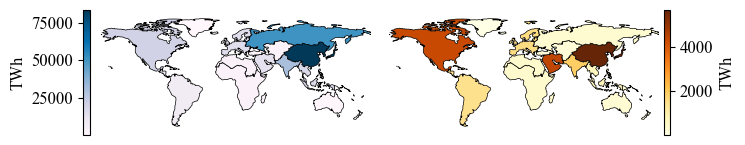

In [ ]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
from matplotlib.colors import Normalize
import matplotlib.cm as cm

installed_capacity_wind_dic = {}
installed_capacity_pv_dic = {}
installed_cap_pv_area = {}
installed_cap_wind_area = {}
curtailment_rel_to_gen = {}
loads_dic = {}
generation_area_dic = {}
generation_dic = {}
installed_cap_land_share = {}
for key, value in regions_dic.items():
    area = region_area(key)
    installed_capacity_wind_dic[key] = value["total_wind_yearly"] * 1e-3 
    installed_capacity_pv_dic[key] = value["total_pv_yearly"] * 1e-3

values_dics = [installed_capacity_wind_dic, installed_capacity_pv_dic]

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(6.6, 2.5))


# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Remove Antarctica
world = world[world['name'] != "Antarctica"]
# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)}, figsize=(6.6, 2.5))

for i, ax in enumerate(axes):
    values_dic = values_dics[i]
    # Add the values to the world GeoDataFrame
    world['value'] = world['bus'].map(values_dic)

    # Merge countries into regions, aggregating only the 'value' column
    regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})

    ax.set_extent([-180, 180, -62, 90], crs=ccrs.PlateCarree())  # Adjust extent as needed

    # Normalize the values for the colormap
    norm = Normalize(vmin=min(values_dic.values()), vmax=max(values_dic.values()))
    cmap = cm.PuBu if i == 0 else cm.YlOrBr

    # Plot regions with the heatmap, making sure normalization is applied
    regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree(), linewidth=0.5)

    ax.spines['geo'].set_visible(False)

    # Create and customize the color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  # Dummy array for the scalar mappable
    
    if i == 0:
        cax = fig.add_axes([0.05, 0.25, 0.01, 0.5])  # Adjust position and width as needed
        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        cbar.ax.yaxis.set_ticks_position('left')
        cbar.ax.yaxis.set_label_position('left')
        cbar.set_label('TWh')
        # cbar.set_ticks([1, 2])  # Customize the ticks
        # cbar.set_ticklabels(['1', '2' ]) 
    else:
        cax = fig.add_axes([0.93, 0.25, 0.01, 0.5])  # Adjust position and width as needed
        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        cbar.set_label('TWh')
        #cbar.set_ticks([2500, 5000, 7500])  # Customize the ticks
        #cbar.set_ticklabels(['1', '2', '3'])  # Customize the tick labels

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])  # Adjust layout to prevent overlap
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures/wind-pv-gen-global-share.svg', format='svg')
plt.show()

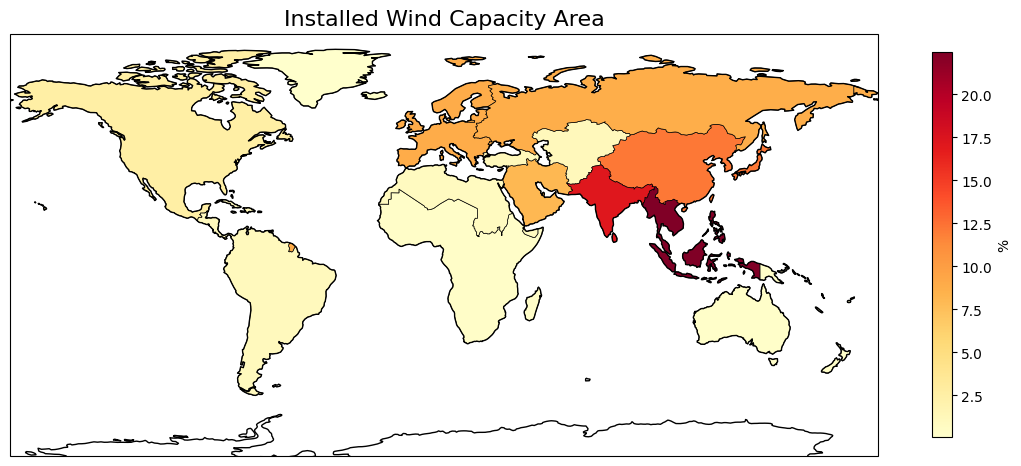

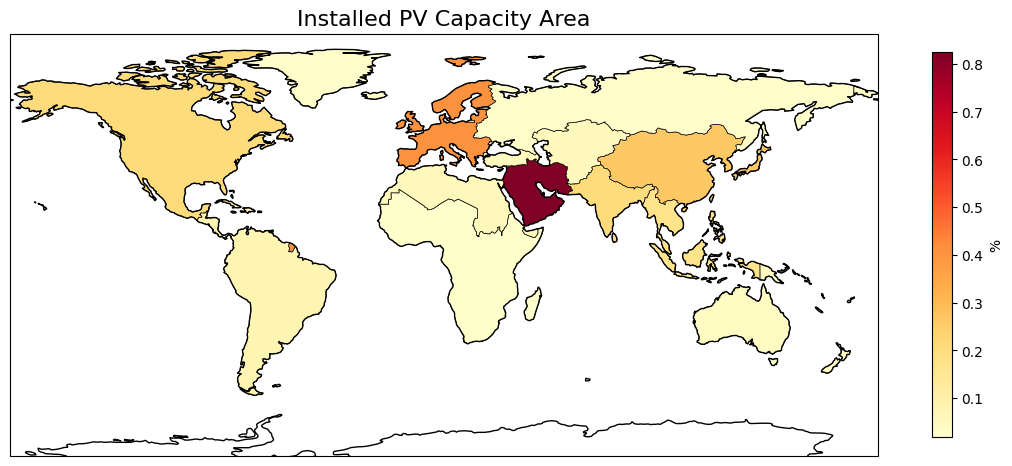

In [ ]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
from matplotlib.colors import Normalize
import matplotlib.cm as cm

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(14, 10))

installed_capacity_wind_dic = {}
installed_capacity_pv_dic = {}
installed_cap_pv_area = {}
installed_cap_wind_area = {}
curtailment_rel_to_gen = {}
loads_dic = {}
generation_area_dic = {}
generation_dic = {}
for key, value in regions_dic.items():
    area = region_area(key)
    installed_cap_wind_area[key] = value["wind_installed"] / 10 / area * 1e9 *100 # to go from GW to to W
    installed_cap_pv_area[key] = value["pv_installed"] / 45 / area * 1e9 * 100
values_dics = [installed_cap_wind_area,  installed_cap_pv_area]

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Remove Antarctica
world = world[world['name'] != "Antarctica"]

# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

for i, values_dic in enumerate(values_dics):
    # Add the values to the world GeoDataFrame
    world['value'] = world['bus'].map(values_dic)

    # Merge countries into regions, aggregating only the 'value' column
    regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})

    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)})
    ax.set_extent([-180, 180, -80, 90], crs=ccrs.PlateCarree())  # Adjust extent as needed

    # Add base map features
    ax.add_feature(cfeature.COASTLINE)

    # Normalize the values for the colormap
    norm = Normalize(vmin=min(values_dic.values()), vmax=max(values_dic.values()))
    cmap = cm.YlOrRd

    # Plot regions with the heatmap, making sure normalization is applied
    regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree(), linewidth=0.5)

    # for i, bus in enumerate(n.buses.index, start=1):
    #     x, y = n.buses.loc[bus, ['x', 'y']]
    #     ax.scatter(x, y, s=400, color='black', edgecolor='k', zorder=5)
    #     ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6)

    # Add a title to the figure
    if i == 0:
        plt.title('Installed Wind Capacity Area', fontsize=16)
    elif i == 1:
        plt.title('Installed PV Capacity Area', fontsize=16)

    # Create and customize the color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  # Dummy array for the scalar mappable
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
    cbar.set_label('%')

    plt.show()


## Power flow chart

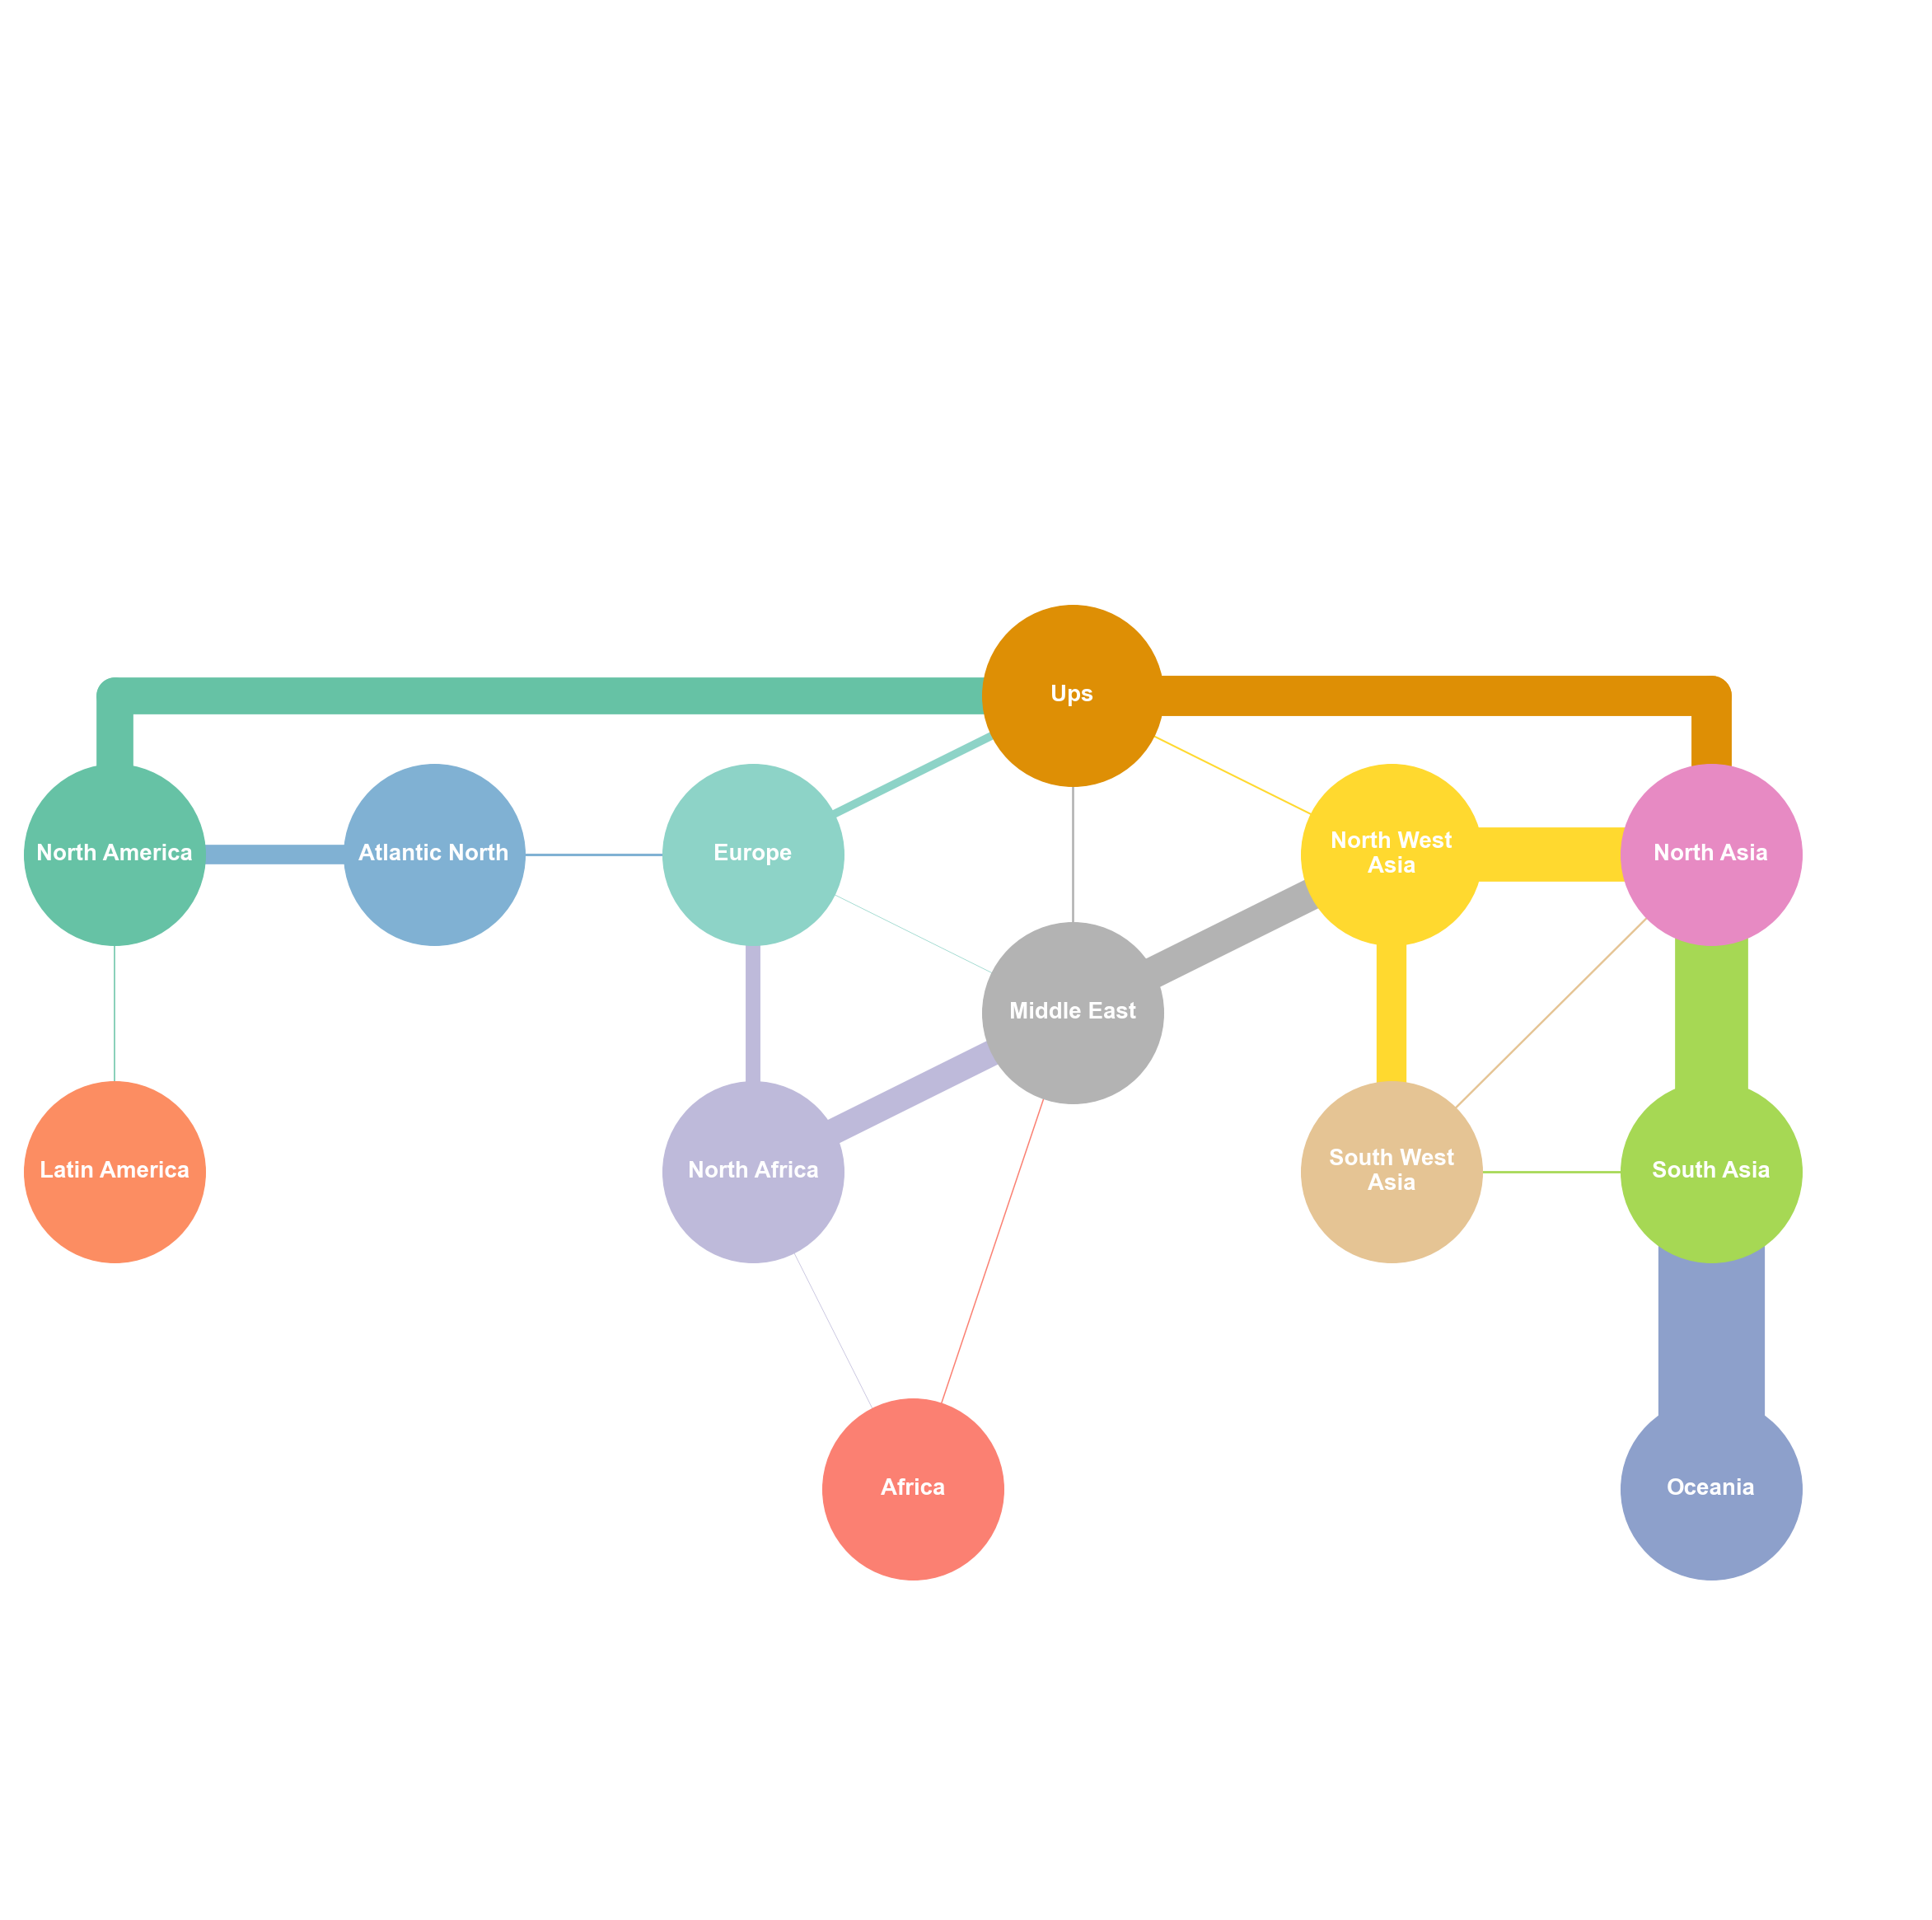

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np


mean_values = [netflows_links_series[key].mean() for (key, value) in netflows_links_series.items()]
std_values = [netflows_links_series[key].std() for (key, value) in netflows_links_series.items()]
plt.rc("figure", figsize=(30, 30))

# Define coordinates for each region
coordinates = {
    "north_africa": (0, 0),
    "europe": (0, 1.5),
    "africa": (0.75, -1.5),
    "middle_east": (1.5, 0.75),
    "north_west_asia": (3, 1.5),
    "south_west_asia": (3, 0),
    "south_asia": (4.5, 0),
    "north_asia": (4.5, 1.5),
    "oceania": (4.5, -1.5),
    "ups": (1.5, 2.25),
    "atlantic_north": (-1.5, 1.5),
    "north_america": (-3, 1.5),  
    "latin_america": (-3, 0)
}

# Scale coordinates to fit the plot
scale = 5
scaled_coordinates = {key: (scale * x, scale * y) for key, (x, y) in coordinates.items()}
arrow_colors = {value['name']: netflows_links[key] for i, (key, value) in enumerate(links_dic.items())}  


# Plotting the network without background map
fig, ax = plt.subplots()
ax.set_xlim(-3.5*scale, 5.5*scale)
ax.set_ylim(-3.5*scale, 5.5*scale)

# Plot nodes
for region_key, (x, y) in scaled_coordinates.items():
    region_key_matched = next((key for key in regions_dic.keys() if key.lower() == region_key.lower()), None)
    if region_key_matched is None:
        continue
    ax.scatter(x, y, s=25000, color=region_colors[region_key_matched], zorder=5)
    region_name = region_key.replace('_', ' ').title()
    words = region_name.split()
    if len(words) == 3:
        region_name = f'{words[0]} {words[1]}\n{words[2]}'
    ax.text(x, y, region_name, color='white', fontsize=20, ha='center', va='center', zorder=6, fontweight='bold')

# Plot lines
for number, (key, value) in enumerate(links_dic.items()):
    bus0 = n.links.loc[f"{value['name']}_0", 'bus0']
    bus1 = n.links.loc[f"{value['name']}_0", 'bus1']
    
    if bus0 is None or bus1 is None:
        print('Region key is none')
        continue
    
    flow = arrow_colors[value['name']]
    linewidth = max(np.abs(flow) / 0.8e8, 0.5)
    color = region_colors.get(bus0 if flow_statements[key] else bus1, 'grey')

    if key == "1_10":
        # Draw the L-shaped line for link 1_10
        ax.plot([-3*scale, -3*scale], [1.5*scale, 2.25*scale], color=color, linewidth=linewidth)
        ax.plot([-3*scale, 1.5*scale], [2.25*scale, 2.25*scale], color=color, linewidth=linewidth)
    elif key == "4_10":
        # Draw the L-shaped line for link 4_10
        ax.plot([1.5*scale, 4.5*scale], [2.25*scale, 2.25*scale], color=color, linewidth=linewidth)
        ax.plot([4.5*scale, 4.5*scale], [2.25*scale, 1.5*scale], color=color, linewidth=linewidth)
    else:
        ax.plot([scaled_coordinates[bus0][0], scaled_coordinates[bus1][0]], 
                [scaled_coordinates[bus0][1], scaled_coordinates[bus1][1]], color=color, linewidth=linewidth)

# Remove axes for a cleaner look
ax.set_axis_off()

plt.show()


# **Checks**

## Check for constant deployed capacity

In [ ]:
for key, value in regions_dic.items():
    wind_gen = n.generators_t.p[f"wind_{key}"] 
    pv_gen = n.generators_t.p[f"pv_{key}"]
    cap_wind = wind_gen / res_potential_dic[key]["wind"]
    cap_pv = pv_gen / res_potential_dic[key]["pv"]
    mean_wind = cap_wind.mean() * 100
    std_wind = cap_wind.std()
    mean_pv = cap_pv.mean() * 100
    std_pv = cap_pv.std()
    print(f'{key} wind: {round(mean_wind, 1)}%, {round(std_wind, 8)}')
    print(f'{key} pv: {round(mean_pv, 1)}%, {round(std_pv, 8)}')

north_america wind: 4.2%, 0.0
north_america pv: 3.2%, 0.00062637
latin_america wind: 22.9%, 0.0
latin_america pv: 1.1%, 0.0
oceania wind: 24.2%, 0.0
oceania pv: 15.8%, 0.0
north_asia wind: 46.3%, 0.0
north_asia pv: 0.0%, 0.0
south_asia wind: 100.0%, 0.0
south_asia pv: 0.0%, 0.0
north_west_asia wind: 25.6%, 0.0
north_west_asia pv: 0.9%, 0.0
south_west_asia wind: 100.0%, 0.0
south_west_asia pv: 0.0%, 0.0
middle_east wind: 68.9%, 0.0
middle_east pv: 0.0%, 0.0
europe wind: 12.0%, 0.0
europe pv: 0.0%, 0.0
ups wind: 0.2%, 0.0
ups pv: 0.7%, 0.00016791
north_africa wind: 19.5%, 0.0
north_africa pv: 13.3%, 0.0
africa wind: 14.0%, 0.0
africa pv: 0.2%, 0.0
atlantic_north wind: 5.2%, 0.0
atlantic_north pv: 0.0%, 0.0


# **Investigation of specific events**

## Highest transmission losses

In [ ]:
index = hourly_losses_rel_to_gen.idxmax()
max_value = hourly_losses_rel_to_gen.max()
print("Index of the maximum value:", index)
print("Maximum value:", max_value)

for key, value in regions_dic.items():
    value[f'gen_max_losses'] = (n.generators_t.p[f"wind_{key}"][index] + n.generators_t.p[f"pv_{key}"][index]) * 1e-3
    value[f'load_max_losses'] = n.loads_t.p[f"load_{key}"][index] * 1e-3
    value[f'cur_max_losses'] = n.generators_t.p[f"curtailment_{key}"][index] * 1e-3

Index of the maximum value: 2050-02-05 15:00:00
Maximum value: 0.08607807718921479


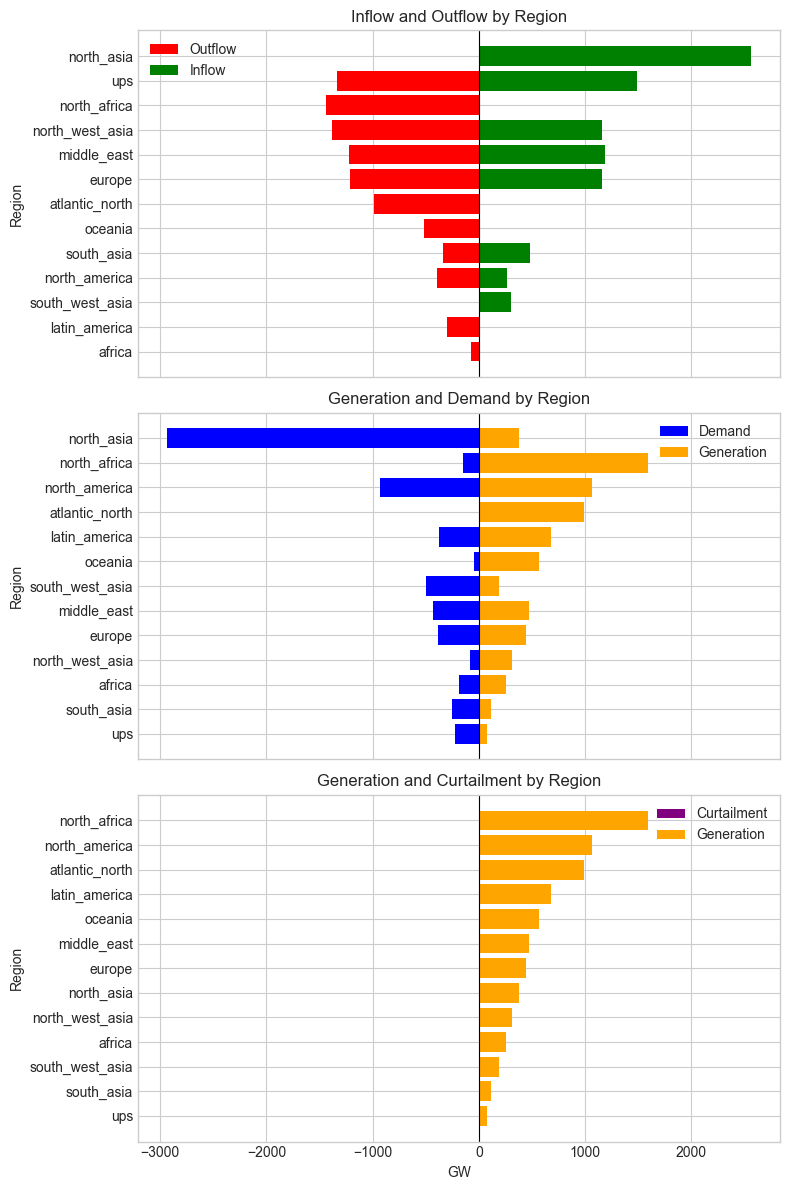

In [ ]:
inflow_outflow_data = [
    (region_key, region_value['inflow_series'][index], region_value['outflow_series'][index])
    for region_key, region_value in regions_dic.items()
]
inflow_outflow_data.sort(key=lambda x: max(x[1], x[2]), reverse=True)

generation_demand_data = [
    (region_key, region_value['gen_max_losses'], region_value['load_max_losses'])
    for region_key, region_value in regions_dic.items()
]
generation_demand_data.sort(key=lambda x: max(x[1], x[2]), reverse=True)

generation_curtailment_data = [
    (region_key, region_value['gen_max_losses'], region_value['cur_max_losses'])
    for region_key, region_value in regions_dic.items()
]
generation_curtailment_data.sort(key=lambda x: max(x[1], x[2]), reverse=True)

regions_inflow_outflow = [item[0] for item in inflow_outflow_data]
inflows = [item[1] for item in inflow_outflow_data]
outflows = [item[2] for item in inflow_outflow_data]

regions_generation_demand = [item[0] for item in generation_demand_data]
generations_demand = [item[1] for item in generation_demand_data]
demands = [item[2] for item in generation_demand_data]

regions_generation_curtailment = [item[0] for item in generation_curtailment_data]
generations_curtailment = [item[1] for item in generation_curtailment_data]
curtailments = [item[2] for item in generation_curtailment_data]

fig, axs = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

axs[0].barh(regions_inflow_outflow, [-outflow for outflow in outflows], color='red', label='Outflow')
axs[0].barh(regions_inflow_outflow, inflows, color='green', label='Inflow')
axs[0].axvline(x=0, color='black', linewidth=0.8)
axs[0].set_ylabel('Region')
axs[0].set_title('Inflow and Outflow by Region')
axs[0].grid(True, axis='x')
axs[0].legend()
axs[0].invert_yaxis()

axs[1].barh(regions_generation_demand, [-demand for demand in demands], color='blue', label='Demand')
axs[1].barh(regions_generation_demand, generations_demand, color='orange', label='Generation')
axs[1].axvline(x=0, color='black', linewidth=0.8)
axs[1].set_ylabel('Region')
axs[1].set_title('Generation and Demand by Region')
axs[1].grid(True, axis='x')
axs[1].legend()
axs[1].invert_yaxis()

axs[2].barh(regions_generation_curtailment, [-curtailment for curtailment in curtailments], color='purple', label='Curtailment')
axs[2].barh(regions_generation_curtailment, generations_curtailment, color='orange', label='Generation')
axs[2].axvline(x=0, color='black', linewidth=0.8)
axs[2].set_xlabel('GW')
axs[2].set_ylabel('Region')
axs[2].set_title('Generation and Curtailment by Region')
axs[2].grid(True, axis='x')
axs[2].legend()
axs[2].invert_yaxis()

plt.tight_layout()
plt.show()

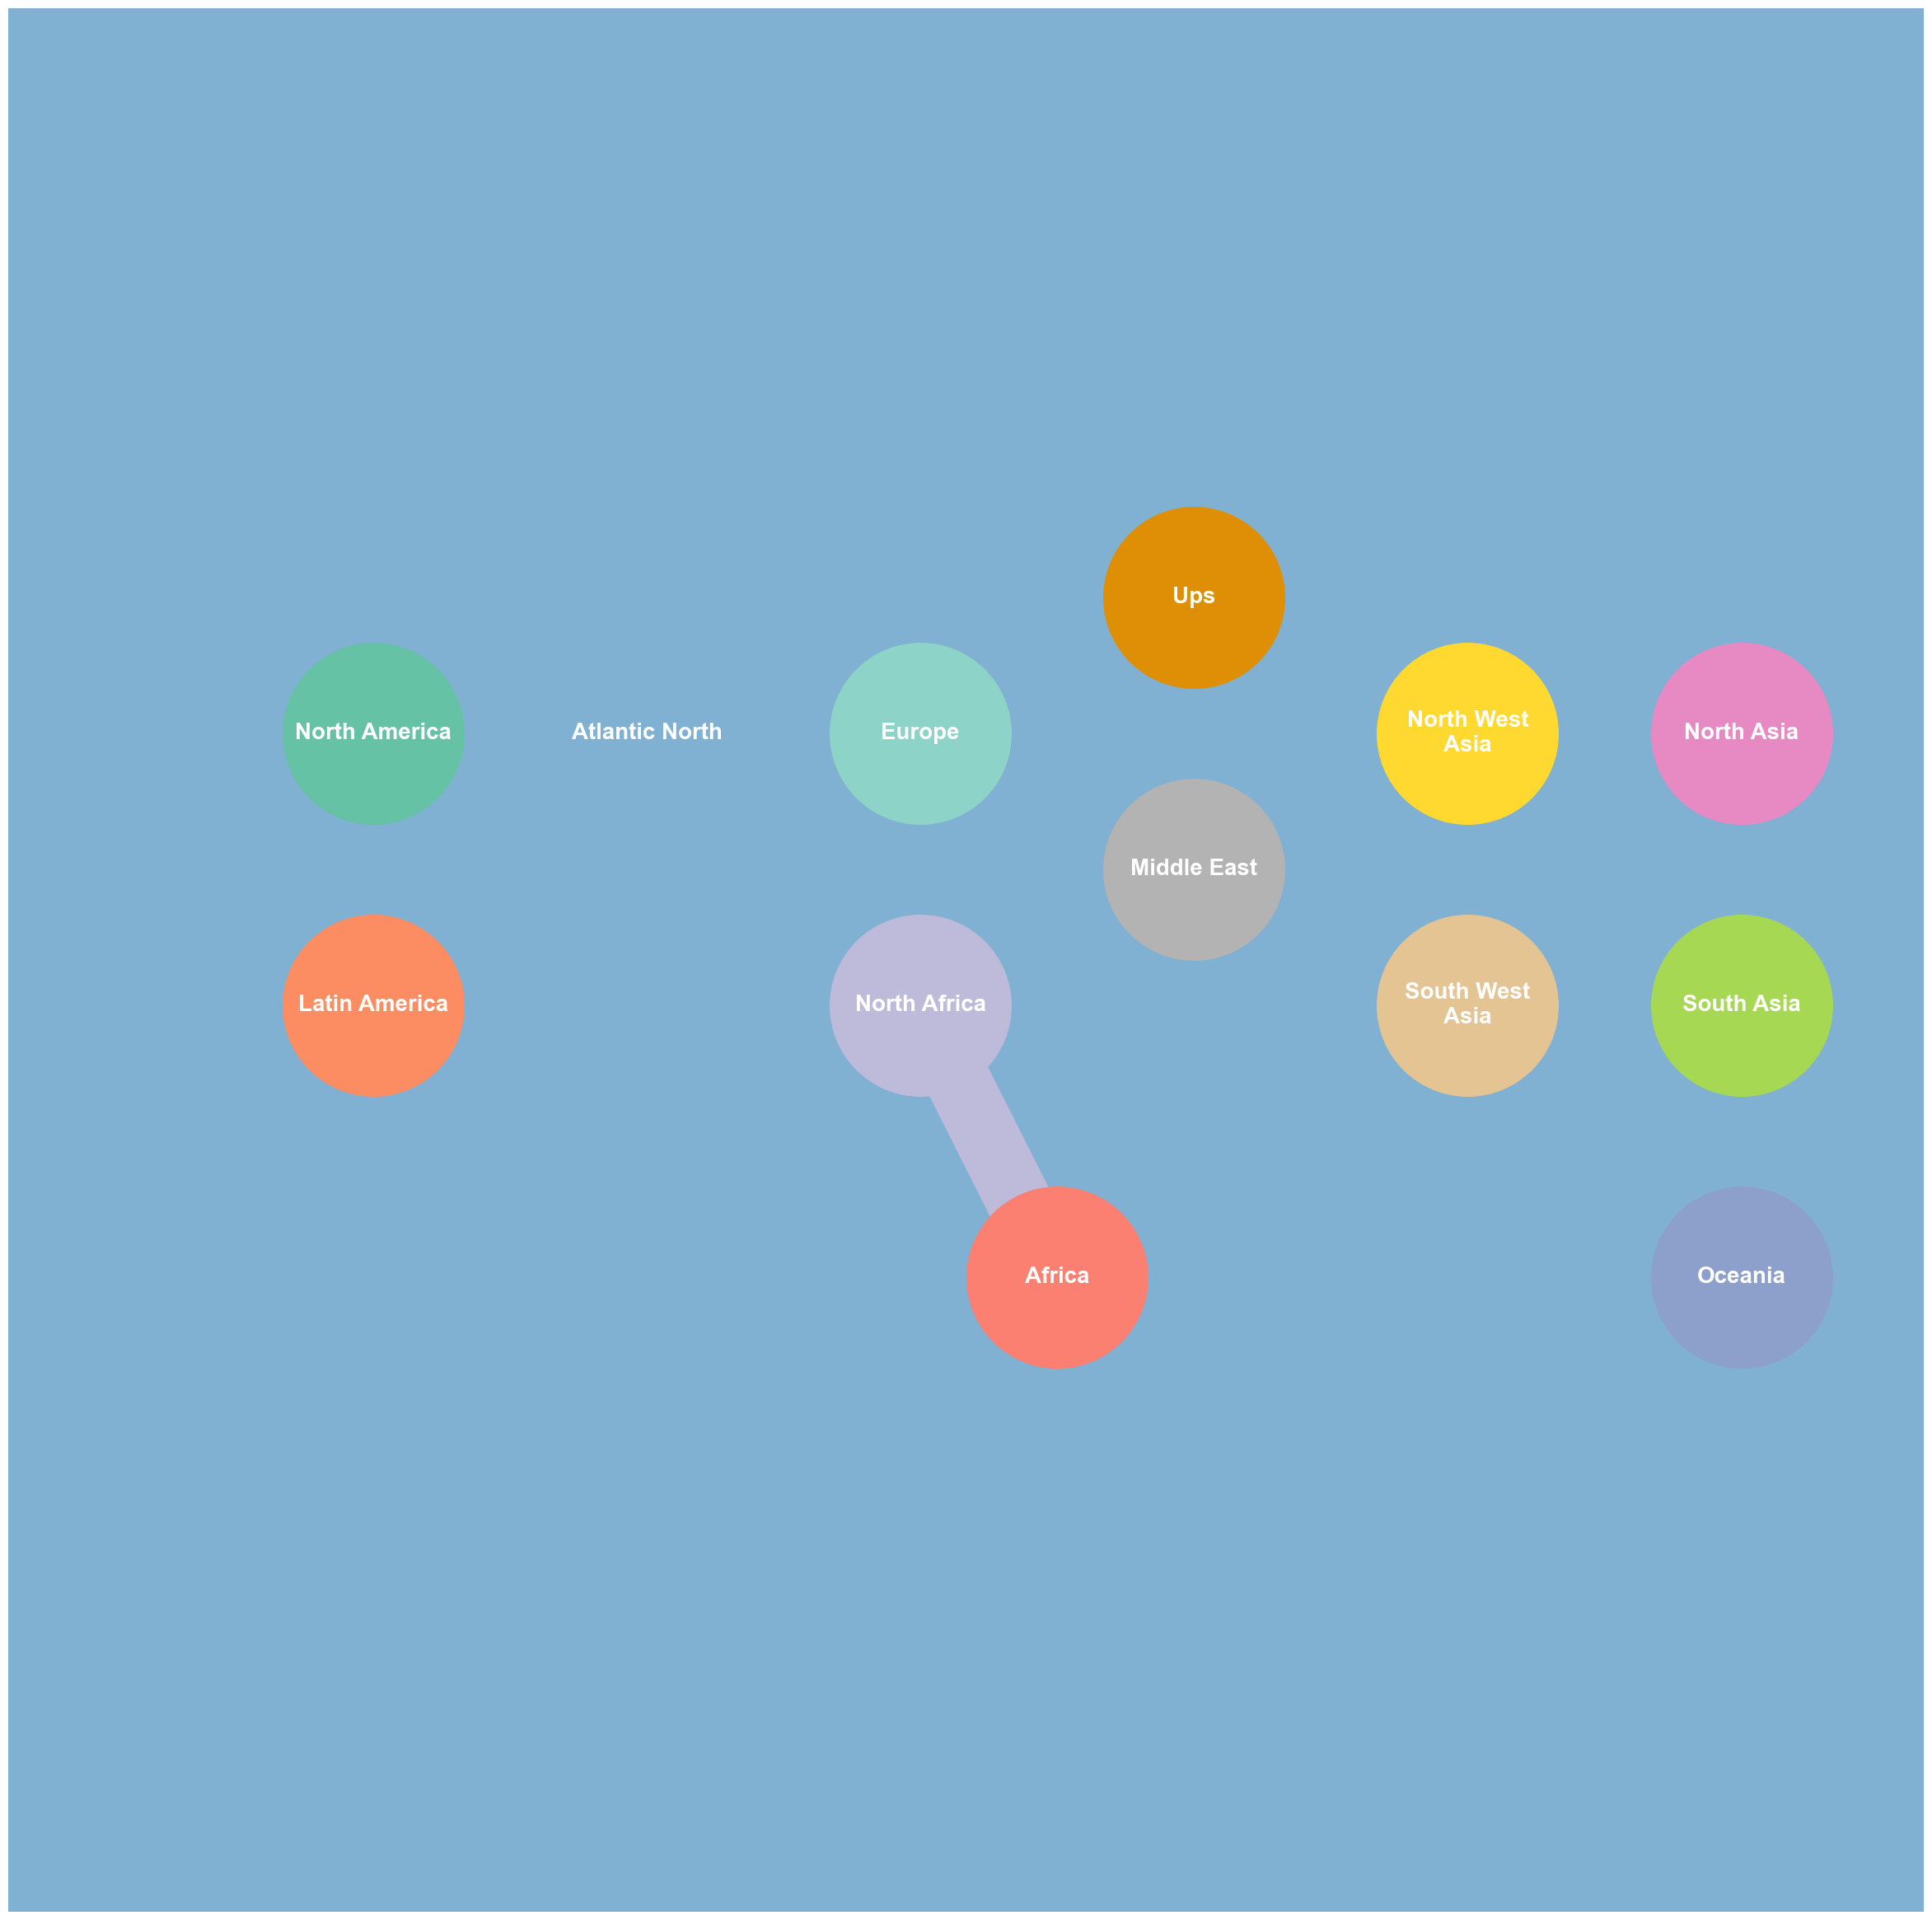

In [ ]:
plt.rc("figure", figsize=(30, 30))

# Define coordinates for each region
coordinates = {
    "north_africa": (0, 0),
    "europe": (0, 1.5),
    "africa": (0.75, -1.5),
    "middle_east": (1.5, 0.75),
    "north_west_asia": (3, 1.5),
    "south_west_asia": (3, 0),
    "south_asia": (4.5, 0),
    "north_asia": (4.5, 1.5),
    "oceania": (4.5, -1.5),
    "ups": (1.5, 2.25),
    "atlantic_north": (-1.5, 1.5),
    "north_america": (-3, 1.5),  
    "latin_america": (-3, 0)
}

# Scale coordinates to fit the plot
scale = 7
scaled_coordinates = {key: (scale * x, scale * y) for key, (x, y) in coordinates.items()}
arrow_colors = {value['name']: netflows_links[key] for i, (key, value) in enumerate(links_dic.items())}  # Example values for color


# Plotting the network without background map
fig, ax = plt.subplots()
ax.set_xlim(-5*scale, 5.5*scale)
ax.set_ylim(-5*scale, 5.5*scale)

# Plot nodes
for region_key, (x, y) in scaled_coordinates.items():
    region_key_matched = next((key for key in regions_dic.keys() if key.lower() == region_key.lower()), None)
    if region_key_matched is None:
        continue
    ax.scatter(x, y, s=25000, color=region_colors[region_key_matched], zorder=5)
    region_name = region_key.replace('_', ' ').title()
    words = region_name.split()
    if len(words) == 3:
        region_name = f'{words[0]} {words[1]}\n{words[2]}'
    ax.text(x, y, region_name, color='white', fontsize=20, ha='center', va='center', zorder=6, fontweight='bold')

# Plot lines
for number, (key, value) in enumerate(links_dic.items()):
    bus0 = n.links.loc[f"{value['name']}_0", 'bus0']
    bus1 = n.links.loc[f"{value['name']}_0", 'bus1']
    
    if bus0 is None or bus1 is None:
        print('Region key is none')
        continue
    
    flow = arrow_colors[value['name']]
    linewidth = max(np.abs(flow) / 1.2e4, 0.1)
    color = region_colors.get(bus0 if flow_statements[key] else bus1, 'grey')

    if key == "1_10":
        # Draw the L-shaped line for link 1_10
        ax.plot([-3*scale, -3*scale], [1.5*scale, 2.25*scale], color=color, linewidth=linewidth)
        ax.plot([-3*scale, 1.5*scale], [2.25*scale, 2.25*scale], color=color, linewidth=linewidth)
    elif key == "4_10":
        # Draw the L-shaped line for link 4_10
        ax.plot([1.5*scale, 4.5*scale], [2.25*scale, 2.25*scale], color=color, linewidth=linewidth)
        ax.plot([4.5*scale, 4.5*scale], [2.25*scale, 1.5*scale], color=color, linewidth=linewidth)
    else:
        ax.plot([scaled_coordinates[bus0][0], scaled_coordinates[bus1][0]], 
                [scaled_coordinates[bus0][1], scaled_coordinates[bus1][1]], color=color, linewidth=linewidth)

# Remove axes for a cleaner look
ax.set_axis_off()

plt.show()


## Curtailment in Atlantic North

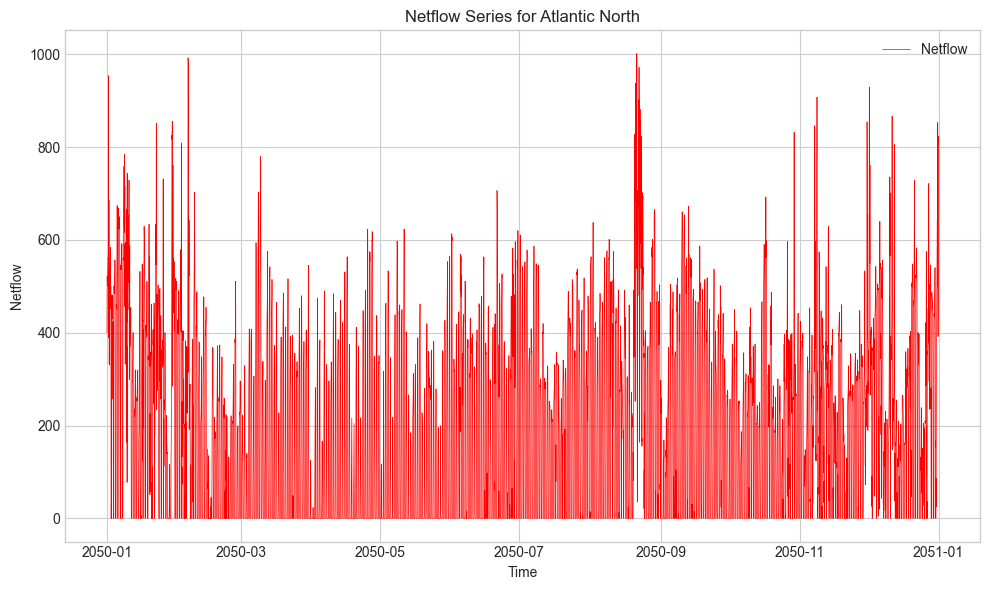

In [ ]:
# Assuming netflow_series is already defined as a pandas Series
curtailment_series = n.generators_t.p['curtailment_atlantic_north'] * 1e-3
netflow_series = regions_dic['atlantic_north']['netflow_series']
daily_netflow = netflow_series.groupby(netflow_series.index.date).sum()
demand_series_north_asia = n.loads_t.p_set['load_north_asia']
daily_demand_north_asia = demand_series_north_asia.groupby(demand_series_north_asia.index.date).sum()
# Plotting the series as a scatter plot
plt.figure(figsize=(10, 6))
#plt.scatter(difference.index, difference.values, label='Netflow', color='blue', s=5)
#plt.scatter(curtailment_series.index, curtailment_series.values, label='Curtailment', color='red', s=5)
plt.plot(netflow_series.index, netflow_series.values, label='Netflow', color='red', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Netflow')
plt.title('Netflow Series for Atlantic North')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

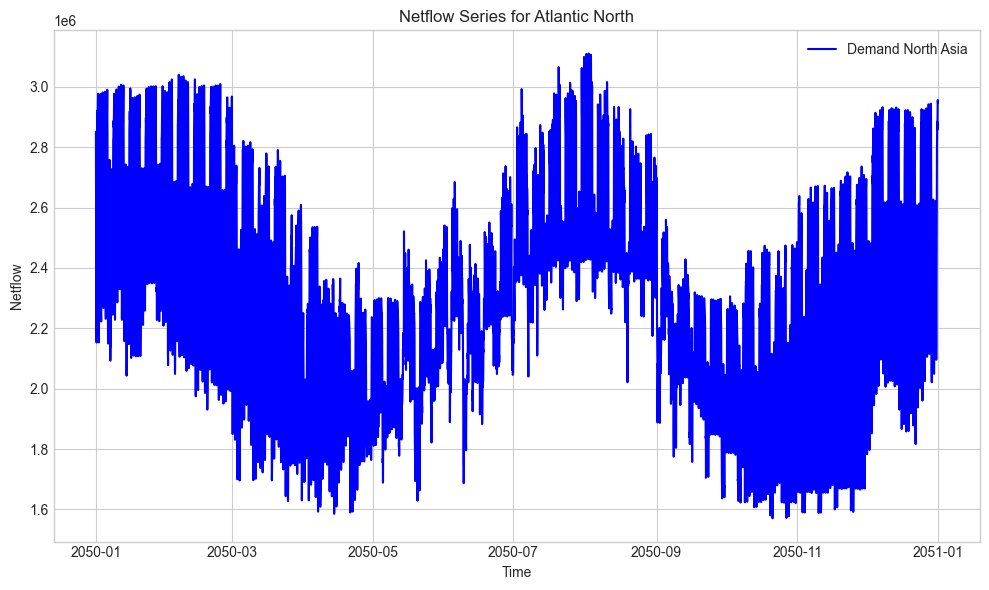

In [ ]:
# Assuming netflow_series is already defined as a pandas Series
curtailment_series = n.generators_t.p['curtailment_atlantic_north'] * 1e-3
netflow_series = regions_dic['atlantic_north']['netflow_series']
daily_netflow = netflow_series.groupby(netflow_series.index.date).sum()
demand_series_north_asia = n.loads_t.p_set['load_north_asia']
daily_demand_north_asia = demand_series_north_asia.groupby(demand_series_north_asia.index.date).sum()
# Plotting the series as a scatter plot
plt.figure(figsize=(10, 6))
plt.plot(demand_series_north_asia.index, demand_series_north_asia.values, label='Demand North Asia', color='blue')
plt.xlabel('Time')
plt.ylabel('Netflow')
plt.title('Netflow Series for Atlantic North')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **Availability of VRE**

# Temporal availability

## Scatter plot of supply over demand 

In [ ]:
demand = 0
supply = 0
for key, value in regions_dic.items():
    demand += n.loads_t.p[f'load_{key}'] * 1e-3 #GW
    supply += (n.generators_t.p[f'wind_{key}'] + n.generators_t.p[f'pv_{key}']) * 1e-3 
demand_supply_ratio = supply / demand
demand_supply_ratio.to_csv('demand_supply_ratio.csv')
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(demand_supply_ratio.index, demand_supply_ratio.values, s=0.3, color='brown', alpha=0.6)
ax.axhline(y=1, color='green', linewidth=1, linestyle='--')
ax.grid(False)
ax.set_ylabel('(-)', fontsize=12)
#ax.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

NameError: name 'regions_dic' is not defined

# **Curtailment**

## Scatter plot global with all the regions

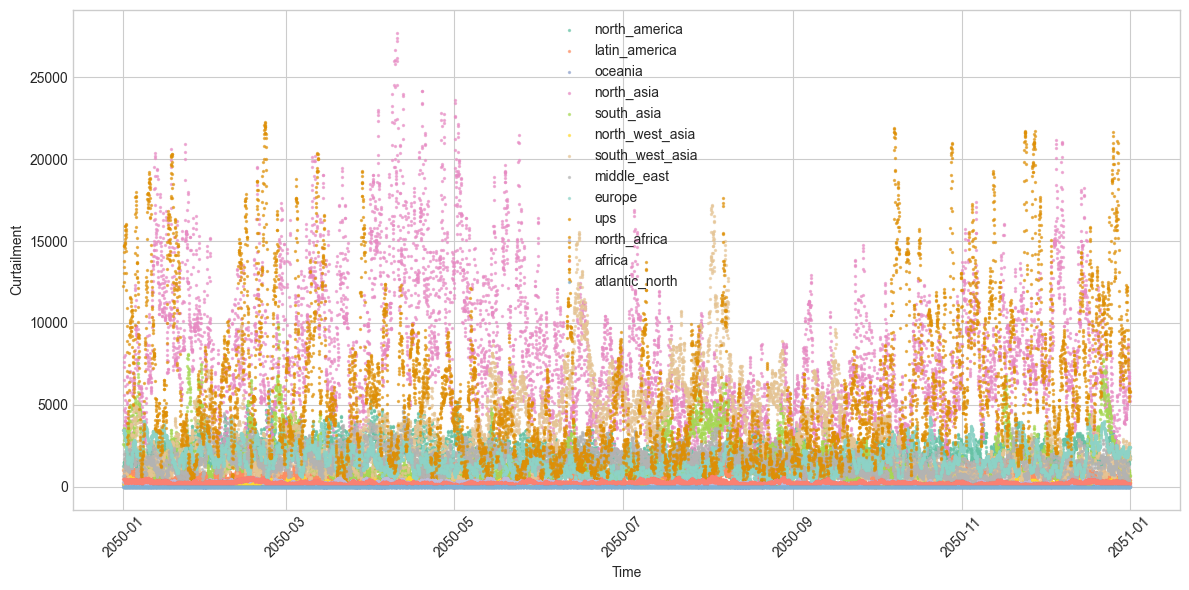

In [ ]:
tolerance = 1e-3 # tolerance for numerical inaccuracies
curtailment = {}
for key, value in regions_dic.items():
    curtailment[key] =  n.generators_t.p[f'curtailment_{key}'] * 1e-3 


fig, ax = plt.subplots(figsize=(12,6))
for key, value in curtailment.items():
    color_ = region_colors[key]
    ax.scatter(value.index, value.values, s=2, color=color_, alpha=0.6, label=f'{key}')

ax.set_xlabel('Time')
ax.set_ylabel('Curtailment')
ax.set_yscale('linear')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

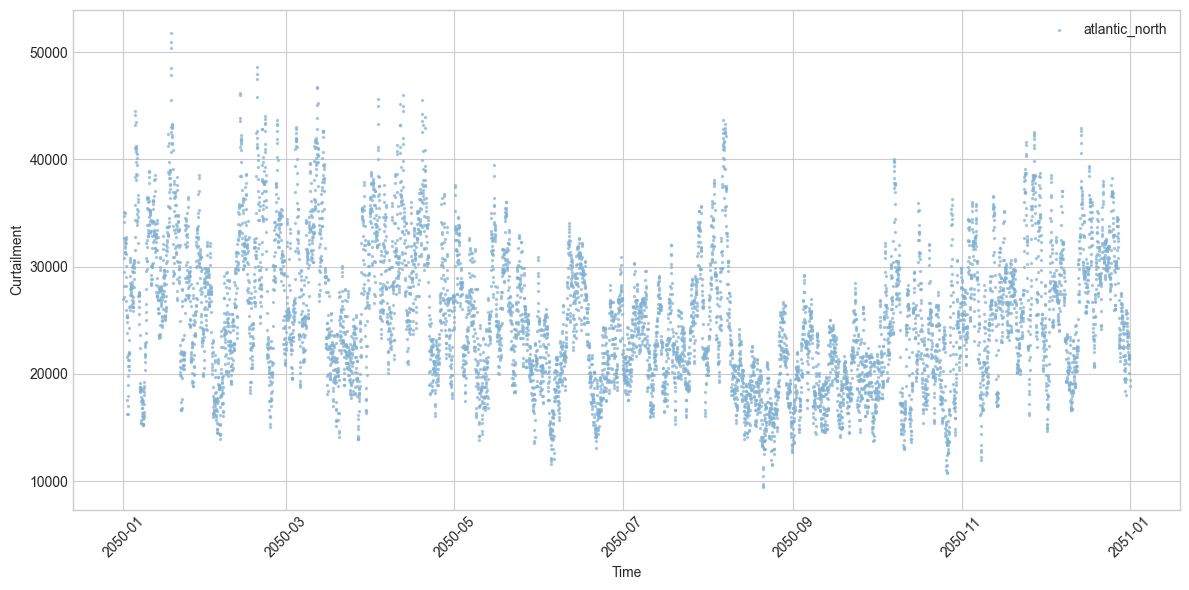

In [ ]:
tolerance = 1e-3 # tolerance for numerical inaccuracies
curtailment = 0
for key, value in regions_dic.items():
    curtailment +=  n.generators_t.p[f'curtailment_{key}'] * 1e-3 

fig, ax = plt.subplots(figsize=(12,6))

ax.scatter(curtailment.index, curtailment.values, s=2, color=color_, alpha=0.6, label=f'{key}')

ax.set_xlabel('Time')
ax.set_ylabel('Curtailment')
ax.set_yscale('linear')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Scatter plot atlantic north

## Time series generation vs demand North Asia

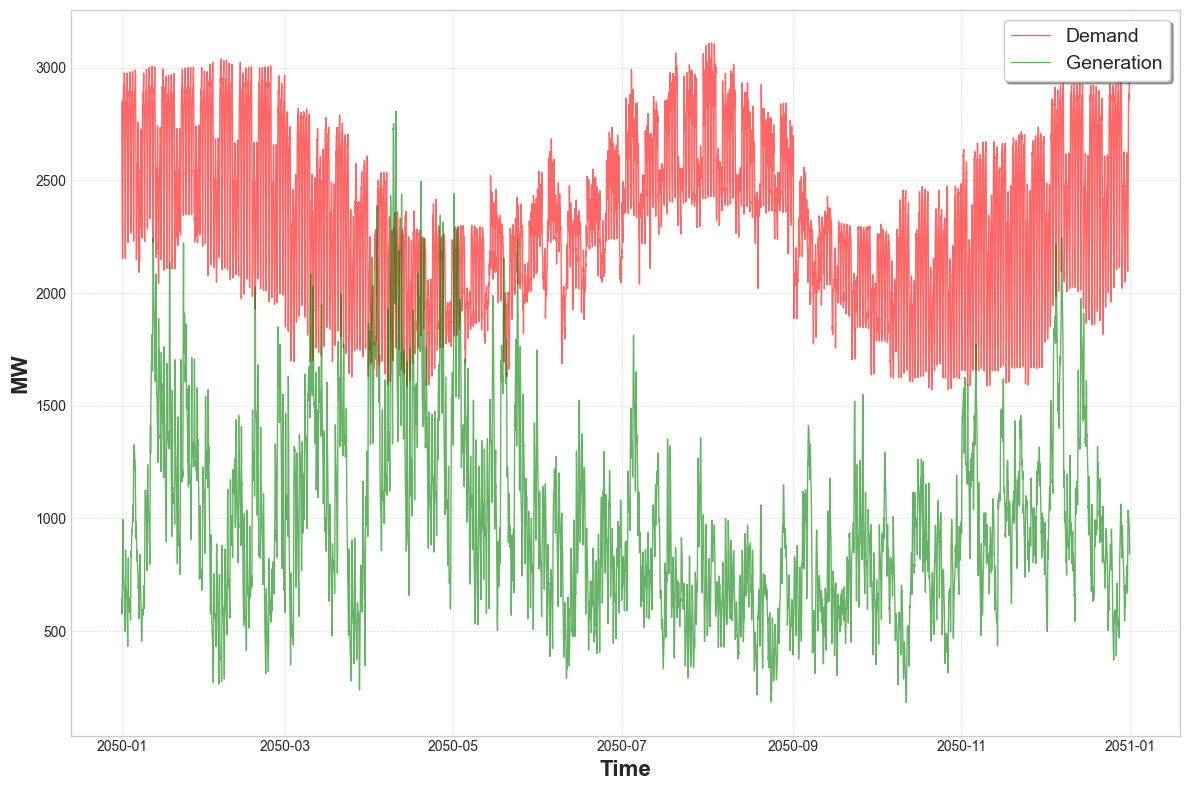

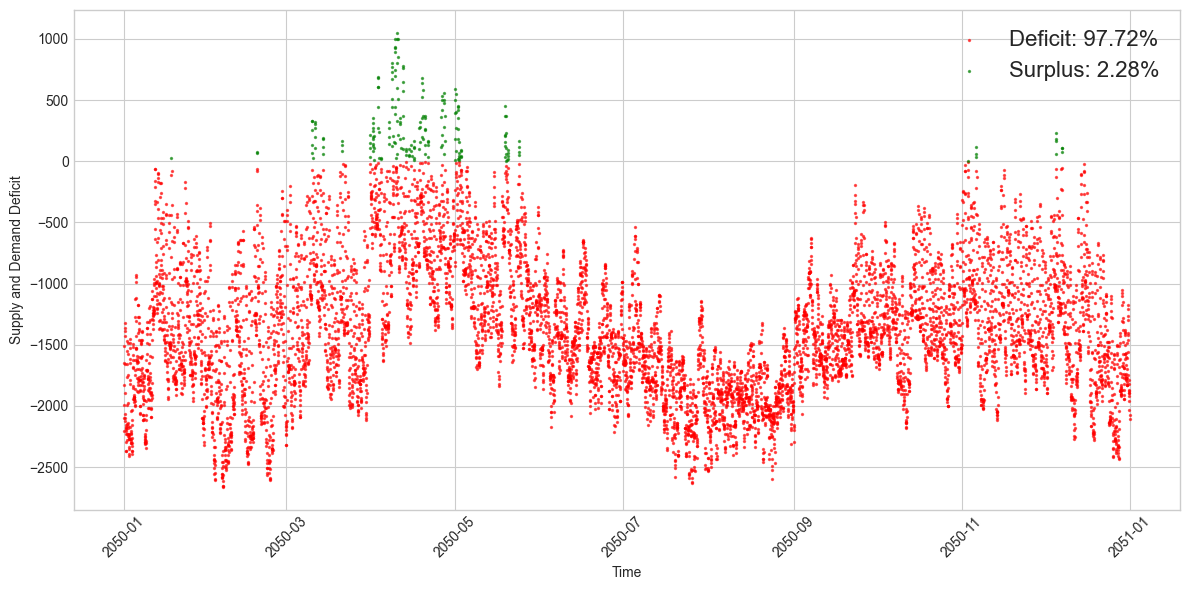

In [ ]:
demand_north_asia = n.loads_t.p[f'load_north_asia'] * 1e-3
gen_north_asia = (n.generators_t.p['wind_north_asia'] + n.generators_t.p['pv_north_asia']) * 1e-3
deficit = gen_north_asia - demand_north_asia

# Graph
plt.figure(figsize=(12, 8))  
plt.plot(demand_north_asia.index, demand_north_asia.values, label='Demand', color='red', linewidth=1, linestyle='-', alpha=0.6)
plt.plot(gen_north_asia.index, gen_north_asia.values, label='Generation', color='green', linewidth=1, linestyle='-', alpha=0.6)
plt.xlabel('Time', fontsize=16, fontweight='bold')  # Increase font size
plt.ylabel('MW', fontsize=16, fontweight='bold')  # Increase font size and add a more descriptive label
plt.legend(loc='upper right', fontsize=14, frameon=True, shadow=True)  # Move legend to upper left, increase font size, add frame and shadow
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Add grid for better readability
plt.tight_layout()  # Adjust layout to fit elements better
plt.show()
plt.show()

# scatter plot
# Calculate percentages
total_points = len(deficit)
points_above_zero = (deficit > 0).sum()
points_below_zero = (deficit <= 0).sum()

percentage_above_zero = (points_above_zero / total_points) * 100
percentage_below_zero = (points_below_zero / total_points) * 100

# Create the scatter plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot points below zero in red
ax.scatter(deficit[deficit <= 0].index, deficit[deficit <= 0].values, s=2, color='red', alpha=0.6, label=f'Deficit: {percentage_below_zero:.2f}%')

# Plot points above zero in green
ax.scatter(deficit[deficit > 0].index, deficit[deficit > 0].values, s=2, color='green', alpha=0.6, label=f'Surplus: {percentage_above_zero:.2f}%')

# Customize the plot
ax.set_xlabel('Time')
ax.set_ylabel('Supply and Demand Deficit')
ax.set_yscale('linear')
ax.legend(fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Time series inflow north asia 

## Fourier series generation vs demand North Asia

## Fourier series inflow north asia

## Fourier series VRE potential atlantic north

## Correlation Matrix of VRE potentials vs Demand 